# TPM034A Machine Learning for socio-technical systems 
## `Assignment 02: Embeddings and Explainable Artificial Intelligence (xAI)`

**Delft University of Technology**<br>
**Q2 2024**<br>
**Instructor:** Sander van Cranenburgh & Giacomo Marangoni <br>
**TAs:**  Francisco Garrido Valenzuela & Lucas Spierenburg <br>

### `Instructions`

**Assignments aim to:**<br>
* Examine your understanding of the key concepts and techniques.
* Examine your the applied ML skills.

**Assignments:**<br>
* Are graded and must be submitted (see the submission instruction below). 

### `Google Colab workspace set-up`

Uncomment the following cells code lines if you are running this notebook on Colab

In [1]:
#!git clone https://github.com/TPM034A/Q2_2024
#!pip install -r Q2_2024/requirements_colab.txt

# `Application: Visual urban environment as component for bike speed and safety` <br>

### **Introduction**

In the previous assignment, you worked with machine learning models to predict cycling speeds using tabular data, such as road infrastructure. While this approach allowed us to explore cycling speeds and make some predictions, it represents only one way to understand and predict cycling dynamics. This assignment builds on your previous work by introducing new datasets and tools to approach the same problem from two different perspectives: exploring the visual components of the urban space for predicting cycling speed, and examining the explainability of cycling accidents.

In the first part of this assignment, you will focus on using images of urban spaces to predict cycling speeds. By generating image embeddings that represent visual features, such as road quality and surrounding infrastructure, you will train machine learning models to incorporate this new dimension of data. This will provide insights into how visual elements contribute to cycling speeds and how they can complement tabular data.

The second part of the assignment shifts the focus to safety and explainability. By integrating accident data with our tabular information, you will explore and explain bike accidents. Using explainable AI techniques, you will interpret model predictions to uncover patterns and risk factors, offering actionable insights for improving urban cycling infrastructure and safety.

#### **Data**
For this assignment you have access to different datasets. All of them will be available in the data folder after the execution of cell below this instructions. The data folder contains four sub-folder: `image_tabular`, `bike_speeds`, `traffic_accidents` and `images`. The following list describes the datasets within the folders.

1. `data/image_tabular/image_metadata.csv`: A csv file with the image metadata (e.g., year, month or location) of Rotterdam images. The column `in_folder` indicates is the img file is present in the `data/images`.
2. `data/image_tabular/image_embeddings.csv`: A tabular csv file with image embeddings from Rotterdam.
3. `data/bike_speeds/bike_speeds.gpkg`: A geo dataset of linestrings (streets) for the Netherlands with bike speed data.
4. `data/traffic_accidents/accident_events.geojson`: A geographical dataset with information and characteristics of accidents for Rotterdam.
5. `data/traffic_accidents/accident_parties.csv`: A tabular csv with the information of the parties involved in the accidents.
6. `data/images`: A folder with image files from Rotterdam. Images in this folder are indicated by the column `in_folder` in `data/image_tabular/image_metadata.csv` with a 1.

As indicated, run the code in the cell below to prepare the dataset. The cell will download the datasets and place them in the data folder automatically for this assigment. It may take up to two minutes to download the data.

Remember to transform all geographical datasets (if it is needed) to the Dutch projection: **28992**.

In [2]:
"""
## IMPORTANT: You have to be on the TUDelft network (eduroam) or under eduVPN to run this script # comment after running
## You can comment these lines after downloading the data.
from assets import data_downloader as dld
dld.download_data()
"""

'\n## IMPORTANT: You have to be on the TUDelft network (eduroam) or under eduVPN to run this script # comment after running\n## You can comment these lines after downloading the data.\nfrom assets import data_downloader as dld\ndld.download_data()\n'

### **Tasks and grading**

Your assignment is divided into two sections: Part I: Image Embeddings, and Part II: Explainable AI. The specific tasks and grading points for each section are outlined below.

1. **Part I: Image embeddings** [5 pts]<br>
    1. **Data preparation and exploration** [1.0 pnt]<br>
        - Loading the datasets. 
        - Preparing the image dataset. 
        - Combining bike speed data with the images. 
        - Exploring the street view images 
    1. **Model training** [2.5 pnt]<br>
        - Data preparation for training (random and spatial) 
        - Training a Linear Regression (LR) 
        - Training a Random Forest (RF) 
        - Training a Multi-Layer Perceptron (MLP) 
    1. **Model selection and application** [1.5 pnt]<br>
        - Discussion on data split
        - Model selection and application
1. **Part II: Explainable AI** [5 pts]<br>
    1. **Data preparation and exploration** [1.0 pnt]<br>
        - Loading the datasets.
        - Combining bike speed data with accidents. 
    1. **Exploring explainability using accidents aggregated by streets** [1.5 pnt]
        - Data preparation
        - Model preparation
        - Explainability
    1. **Exploring explainability using accidents instances** [1.5 pnt]
        - Data preparation
        - Model preparation
        - Explainability
    1. **Reflection** [1.0 pnt]

    ### **Submission**
- The deadline for this assignment is **Monday, December 12th, 2024** 
- Use **Python 3.11**
- You have to submit your work in ipynb **(fully executed)** into Brightspace.

In [3]:
# Data manipulation
import numpy as np
import pandas as pd
import geopandas as gpd

# Plotting and visualization
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import contextily as ctx

# Machine learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Explainaibility AI
import shap
from lime import lime_tabular

# Others
from shapely.geometry import Point
from pathlib import Path

# pd settings
pd.set_option('display.max_columns', None)

## Part I: Image embeddings
### **1. Data preparation and exploration**
#### **1.1. Loading datasets.** Load the datasets from the folders: image_tabular and bike_speeds. Explore them with `df.head()` for you to familiarize with the tables.

In [4]:
img_embeddings = pd.read_csv("data/image_tabular/image_embeddings.csv")   #image embedding features
img_metadata = pd.read_csv("data/image_tabular/image_metadata.csv")       #image metadata (location, path, folder...)
bike_speeds = gpd.read_file("data/bike_speeds/bike_speeds.gpkg")          #speed and characteristics of the road

In [5]:
img_embeddings.head()

img_id   Fhat000   Fhat001   Fhat002   Fhat003   Fhat004   Fhat005  \
0       0 -0.721522  0.232802  0.139053  0.332571 -0.643862  0.063346   
1       1 -0.623503  0.638402  0.658155  0.192114 -0.627638  0.011822   
2       2 -0.100401  0.421808  1.200465 -0.040461 -0.798148 -0.101276   
3       3  0.161000  0.808097  0.024000  0.184818 -0.909536  0.111023   
4       4  0.643868  0.463769  0.912675 -0.136469 -0.955919 -0.282816   

    Fhat006   Fhat007   Fhat008   Fhat009   Fhat010   Fhat011   Fhat012  \
0 -0.143065  0.197804  0.627572 -0.113160  0.103848  0.349531 -0.454116   
1 -0.144213  0.119007  0.454119 -0.187807  0.283838  0.119964 -0.421312   
2 -0.656213  0.018648 -0.331052 -0.089506  0.732166  0.118592 -0.160782   
3 -0.225173  0.245244 -0.088505 -0.184186  0.389606  0.156294 -0.456531   
4 -0.506169 -0.169948 -0.242296 -0.044370  0.775208 -0.027459 -0.214341   

    Fhat013   Fhat014   Fhat015   Fhat016   Fhat017   Fhat018   Fhat019  \
0  0.156431 -0.173558  0.093596 -0.024934 -0.183208 -0.329915  0.334317   
1  0.292101 -0.109635  0.278526  0.025043 -0.273027 -0.256410  0.200388   
2  0.345163  0.127025 -0.053597 -0.061117  0.003480 -0.470245 -0.163239   
3  0.319890 -0.299665  0.083257 -0.193682 -0.133317 -0.243234  0.292501   
4  0.479707 -0.251963  0.126639 -0.009587  0.236805 -0.441034 -0.283703   

    Fhat020   Fhat021   Fhat022   Fhat023   Fhat024  
0 -0.034518 -0.005868 -0.170634 -0.033538 -0.085577  
1 -0.166567  0.180788 -0.246929  0.179483  0.129283  
2  0.103589 -0.206567 -0.512829 -0.079979 -0.046585  
3 -0.263785 -0.194097 -0.337674 -0.119035  0.036482  
4 -0.013882  0.274577 -0.402516 -0.147622  0.223398

In [6]:
img_metadata.head()

img_id              img_path  year  month        lat       lng  \
0       0  image_261669_s_a.png  2019      5  51.992875  4.595223   
1       1  image_261609_s_a.png  2021      1  51.992723  4.595357   
2       2  image_261683_s_a.png  2017      7  51.993201  4.594991   
3       3  image_261590_s_a.png  2016      7  51.991961  4.595907   
4       4  image_261599_s_a.png  2017      7  51.992304  4.595650   

            hex_id  attractiveness  in_folder  
0  8b19694da002fff        0.745663          0  
1  8b19694da003fff        0.729360          0  
2  8b19694da006fff        0.767513          0  
3  8b19694da008fff        0.721686          0  
4  8b19694da00efff        0.572475          0

In [7]:
bike_speeds.head()

u           v  oneway          name   highway  reversed   length  \
0  23718802  3402771433   False  Hoofboschpad  cycleway     False    3.044   
1  23718802  1433962879   False  Hoofboschpad  cycleway      True   13.290   
2  23718816  1433962829   False  Hoofboschpad  cycleway     False  125.769   
3  23718816  1433962864   False  Hoofboschpad  cycleway      True    9.008   
4  23718911  1510273931   False  Hoofboschpad  cycleway     False   89.782   

      speed  n_observations                                           geometry  
0  18.07910           115.0  LINESTRING (85623.723 444238.96, 85624.403 444...  
1  18.07910           115.0  LINESTRING (85623.723 444238.96, 85617.794 444...  
2   9.42293             1.0  LINESTRING (85605.755 444214.675, 85491.953 44...  
3  18.07910           115.0  LINESTRING (85605.755 444214.675, 85613.983 44...  
4  20.80010           117.0  LINESTRING (85350.354 443827.325, 85376.614 44...

#### **1.2. Preparing the image dataset.** Combine the `img_metadata` dataframe with the `img_embeddings` for consolidating it in one unique dataframe.  

In [8]:
img_data = pd.merge(img_embeddings, img_metadata, on='img_id', how='inner')

img_data.head(10)

img_id   Fhat000   Fhat001   Fhat002   Fhat003   Fhat004   Fhat005  \
0       0 -0.721522  0.232802  0.139053  0.332571 -0.643862  0.063346   
1       1 -0.623503  0.638402  0.658155  0.192114 -0.627638  0.011822   
2       2 -0.100401  0.421808  1.200465 -0.040461 -0.798148 -0.101276   
3       3  0.161000  0.808097  0.024000  0.184818 -0.909536  0.111023   
4       4  0.643868  0.463769  0.912675 -0.136469 -0.955919 -0.282816   
5       5 -1.475049 -0.040805  0.076299  0.463767  0.175463 -0.489753   
6       6 -1.188484 -0.023585  0.233175  0.679122 -0.559324  0.068004   
7       7 -0.523108  0.697807  0.638292  0.480776 -0.656989 -0.049192   
8       8 -0.384486  1.154639  0.538626  0.396040  0.232002  0.077949   
9       9 -0.511161  1.039197  0.480532  0.229521 -0.186685 -0.194484   

    Fhat006   Fhat007   Fhat008   Fhat009   Fhat010   Fhat011   Fhat012  \
0 -0.143065  0.197804  0.627572 -0.113160  0.103848  0.349531 -0.454116   
1 -0.144213  0.119007  0.454119 -0.187807  0.283838  0.119964 -0.421312   
2 -0.656213  0.018648 -0.331052 -0.089506  0.732166  0.118592 -0.160782   
3 -0.225173  0.245244 -0.088505 -0.184186  0.389606  0.156294 -0.456531   
4 -0.506169 -0.169948 -0.242296 -0.044370  0.775208 -0.027459 -0.214341   
5  0.537176 -0.094827  0.318037  0.064138 -0.399988  0.196581  0.030343   
6 -0.191779  0.173779  0.683503 -0.173334  0.080418  0.207144 -0.425192   
7 -0.448003  0.268965  0.326054 -0.418323  0.358216 -0.220973 -0.150161   
8 -0.005493 -0.025644  0.645558  0.155243  0.238203  0.279322 -0.018356   
9  0.066933  0.243889  0.383367 -0.125237  0.022620  0.325005 -0.086226   

    Fhat013   Fhat014   Fhat015   Fhat016   Fhat017   Fhat018   Fhat019  \
0  0.156431 -0.173558  0.093596 -0.024934 -0.183208 -0.329915  0.334317   
1  0.292101 -0.109635  0.278526  0.025043 -0.273027 -0.256410  0.200388   
2  0.345163  0.127025 -0.053597 -0.061117  0.003480 -0.470245 -0.163239   
3  0.319890 -0.299665  0.083257 -0.193682 -0.133317 -0.243234  0.292501   
4  0.479707 -0.251963  0.126639 -0.009587  0.236805 -0.441034 -0.283703   
5 -0.122864 -0.281369  0.101917 -0.743189  0.008737 -0.455131  0.226380   
6  0.324973 -0.214424  0.186608  0.100146 -0.247300 -0.233864  0.342939   
7  0.428294 -0.319846  0.101257 -0.203326 -0.040770 -0.519427  0.165544   
8  0.200989 -0.162420 -0.313266  0.012872  0.034768 -0.247498  0.686687   
9  0.444974 -0.355155 -0.080890  0.223954  0.018540 -0.490491  0.594919   

    Fhat020   Fhat021   Fhat022   Fhat023   Fhat024              img_path  \
0 -0.034518 -0.005868 -0.170634 -0.033538 -0.085577  image_261669_s_a.png   
1 -0.166567  0.180788 -0.246929  0.179483  0.129283  image_261609_s_a.png   
2  0.103589 -0.206567 -0.512829 -0.079979 -0.046585  image_261683_s_a.png   
3 -0.263785 -0.194097 -0.337674 -0.119035  0.036482  image_261590_s_a.png   
4 -0.013882  0.274577 -0.402516 -0.147622  0.223398  image_261599_s_a.png   
5  0.263506 -0.131515  0.125307  0.164646 -0.059084  image_261582_s_a.png   
6  0.006620 -0.142920 -0.173282 -0.146003 -0.110578  image_261693_s_a.png   
7 -0.049893  0.475114 -0.581232  0.031870 -0.092578  image_261711_s_a.png   
8 -0.267584 -0.036870  0.136997  0.212654  0.101243  image_261724_s_a.png   
9 -0.406604 -0.159731 -0.198696  0.123303 -0.051203  image_261560_s_a.png   

   year  month        lat       lng           hex_id  attractiveness  \
0  2019      5  51.992875  4.595223  8b19694da002fff        0.745663   
1  2021      1  51.992723  4.595357  8b19694da003fff        0.729360   
2  2017      7  51.993201  4.594991  8b19694da006fff        0.767513   
3  2016      7  51.991961  4.595907  8b19694da008fff        0.721686   
4  2017      7  51.992304  4.595650  8b19694da00efff        0.572475   
5  2015      6  51.991653  4.594184  8b19694da01bfff        0.353003   
6  2019      5  51.993835  4.594537  8b19694da032fff        0.676711   
7  2015      6  51.993636  4.594679  8b19694da033fff        0.783889   
8  2021      1  51.994164  4.594309  8b19694da036ff

In [9]:
# Convert lat/long to geometry (Point)
img_data['geometry'] = img_data.apply(lambda row: Point(row['lng'], row['lat']), axis=1)

# Convert to GeoDataFrame with WGS84 CRS (EPSG:4326)
img_data = gpd.GeoDataFrame(img_data, geometry='geometry', crs="EPSG:4326")

# Reproject to Dutch projection (EPSG:28992)
img_data = img_data.to_crs("EPSG:28992")

#### **1.3. Combining bike speed data with the image embeddings** 
- (a) Link the bike speed data (represented as linestrings for streets) with the images (represented as point locations). You can apply any suitable spatial aggregation method to join the data. *HINT*: Use 'u-v' as the unique identifier for each street to keep each street only one time, and consider using the buffer function in GeoPandas for this task.
- (b) As one street object may contain several images, group by the rows by the street and average the embedding features. As a result you should have each street once. Remove the columns that doesn't make sense to have and include the linestring geometry.
- (c) Visualize the result in a map. Plot the all images (points) and resulting streets with image data. For better visualization just show Y within 436000-438000 and X within 92000-96000 (using EPSG:28992)

In [10]:
#(a)
# First combine 'u' and 'v' to create a unique identifier
bike_speeds['u-v'] = bike_speeds['u'].astype(str) + '-' + bike_speeds['v'].astype(str)

# Move 'u-v' to the beginning of the DataFrame (easier to understand for layout)
columns = ['u-v'] + [col for col in bike_speeds.columns if col != 'u-v']
bike_speeds = bike_speeds[columns]

#Drop the 'u' and 'v' columns
bike_speeds = bike_speeds.drop(columns = ['u', 'v', 'name'], errors='ignore')

# Buffer the streets to associate images with streets
buffered_streets = bike_speeds.copy()
buffered_streets['geometry'] = buffered_streets.geometry.buffer(5)      #I use 5 meters to have photos close to the street that could better represent the road and not other objects and avoid many duplicates between nearby streets

# Spatial join to link images with streets
street_images = gpd.sjoin(buffered_streets, img_data, how='inner', predicate='intersects')

street_images.head(10)

u-v  oneway      highway  reversed   length   speed  \
47  26911590-8193684771   False     cycleway     False    4.555  12.687   
47  26911590-8193684771   False     cycleway     False    4.555  12.687   
47  26911590-8193684771   False     cycleway     False    4.555  12.687   
47  26911590-8193684771   False     cycleway     False    4.555  12.687   
48    26911590-44412339   False  residential     False  115.110  16.859   
48    26911590-44412339   False  residential     False  115.110  16.859   
48    26911590-44412339   False  residential     False  115.110  16.859   
48    26911590-44412339   False  residential     False  115.110  16.859   
48    26911590-44412339   False  residential     False  115.110  16.859   
48    26911590-44412339   False  residential     False  115.110  16.859   

    n_observations                                           geometry  \
47             4.0  POLYGON ((93410.662 437508.436, 93410.498 4375...   
47             4.0  POLYGON ((93410.662 437508.436, 93410.498 4375...   
47             4.0  POLYGON ((93410.662 437508.436, 93410.498 4375...   
47             4.0  POLYGON ((93410.662 437508.436, 93410.498 4375...   
48             7.0  POLYGON ((93520.323 437557.848, 93520.781 4375...   
48             7.0  POLYGON ((93520.323 437557.848, 93520.781 4375...   
48             7.0  POLYGON ((93520.323 437557.848, 93520.781 4375...   
48             7.0  POLYGON ((93520.323 437557.848, 93520.781 4375...   
48             7.0  POLYGON ((93520.323 437557.848, 93520.781 4375...   
48             7.0  POLYGON ((93520.323 437557.848, 93520.781 4375...   

    index_right  img_id   Fhat000   Fhat001   Fhat002   Fhat003   Fhat004  \
47        18849   18849 -0.291683 -0.390081  1.473776 -0.170236  0.462563   
47        69571   69571 -0.009342 -0.515756  0.120826 -0.310779  0.792671   
47        44210   44210 -0.082596  0.014728  1.321794  0.144909  0.502265   
47        94932   94932  1.368951  0.096749  0.804723  0.598280  0.330794   
48        18849   18849 -0.291683 -0.390081  1.473776 -0.170236  0.462563   
48        69571   69571 -0.009342 -0.515756  0.120826 -0.310779  0.792671   
48        44210   44210 -0.082596  0.014728  1.321794  0.144909  0.502265   
48        94932   94932  1.368951  0.096749  0.804723  0.598280  0.330794   
48        43881   43881 -0.273275 -1.311514  0.628609  0.120064  0.280841   
48        94603   94603  0.237638 -0.850062 -0.030505  0.909102 -0.047859   

     Fhat005   Fhat006   Fhat007   Fhat008   Fhat009   Fhat010   Fhat011  \
47  0.247874  0.275621 -0.189034 -0.382739  0.310310 -0.486027 -0.668795   
47 -0.073027 -0.112850  0.467054 -0.627903  0.456303  0.384389  0.322181   
47 -0.018395  0.106609 -0.225512 -0.371230  0.403128 -0.048473 -0.339075   
47  0.109849 -0.342466 -0.226191 -0.225441  0.285973  0.073574 -0.143254   
48  0.247874  0.275621 -0.189034 -0.382739  0.310310 -0.486027 -0.668795   
48 -0.073027 -0.112850  0.467054 -0.627903  0.456303  0.384389  0.322181   
48 -0.018395  0.106609 -0.225512 -0.371230  0.403128 -0.048473 -0.339075   
48  0.109849 -0.342466 -0.226191 -0.225441  0.285973  0.073574 -0.143254   
48 -0.509801  0.125543  0.462737 -0.738263 -0.320138  0.290526  0.168754   
48  0.712390  0.524829 -0.132498 -0.490122  0.331787  0.452112 -0.366498   

     Fhat012   Fhat013   Fhat014   Fhat015   Fhat016   Fhat017   Fhat018  \
47 -0.379140 -0.376582  0.814294  0.355912  0.071222 -0.154991  0.042055   
47  0.135870  0.005446  0.405951  0.252065 -0.070955 -0.161904 -0.195775   
47 -0.389338 -0.185132  0.712395  0.322462 -0.149472 -0.129817 -0.179089   
47  0.118540  0.128393  0.524235  0.472450  0.037747  0.150977 -0.376577   
48 -0.379140 -0.376582  0.814294  0.355912  0.071222 -0.154991  0.042055   
48  0.135870  0.005446  0.405951  0.252065 -0.070955 -0.161904 -0.195775   
48 -0.389338 -0.185132  0.712395  0.322462 -0.149472 -0.129817 -0.179089   
48  0.118540  0.128393  0.524235  0.472450  0.037747  0.150977 -0.376577   
48 -0.019923 -0.29099

In [11]:
#(b)
# Group by 'u-v' and aggregate
embedding_columns = [col for col in img_data.columns if col.startswith('Fhat')]
aggregation = {
    **{col: 'mean' for col in embedding_columns},           # Average embeddings
}

# Perform groupby and aggregation
street_embeddings = street_images.groupby('u-v').agg(aggregation).reset_index()

# Merge aggregated data back to bike_speeds
result = bike_speeds.merge(street_embeddings, on='u-v')

final_dataset = result.drop(columns=[ 'n_observations'])

final_dataset.head(10)

u-v  oneway      highway  reversed   length    speed  \
0  26911590-8193684771   False     cycleway     False    4.555  12.6870   
1    26911590-44412339   False  residential     False  115.110  16.8590   
2    26911590-44409291   False  residential      True   28.554  14.7160   
3    26911590-44408715   False  residential      True   97.694  15.7445   
4  26911597-8193684771   False     cycleway      True   60.956  16.8590   
5  29184429-8562077285    True     cycleway     False    9.066  10.2443   
6  29335572-5057722508   False  residential     False   25.219      NaN   
7  29335575-8639488779   False      footway      True   12.312      NaN   
8  29335628-8639488818   False      footway     False   12.137      NaN   
9  29335630-5057722512   False      footway      True    5.310      NaN   

                                            geometry   Fhat000   Fhat001  \
0  LINESTRING (93417.022 437506.124, 93415.285 43...  0.246333 -0.198590   
1  LINESTRING (93417.022 437506.124, 93522.366 43...  0.029952 -0.210926   
2  LINESTRING (93417.022 437506.124, 93429.052 43...  0.246333 -0.198590   
3  LINESTRING (93417.022 437506.124, 93324.89 437...  0.298982 -0.128039   
4  LINESTRING (93392.004 437566.739, 93415.285 43...  0.246333 -0.198590   
5  LINESTRING (93816.602 437532.429, 93823.993 43... -0.098209 -0.199150   
6  LINESTRING (97827.089 433863.383, 97821.132 43...  0.363423  0.343434   
7  LINESTRING (97808.692 433901.869, 97820.75 433... -0.746032  0.145196   
8  LINESTRING (97662.173 433866.149, 97673.993 43... -0.223056  0.492649   
9  LINESTRING (97681.714 433859.761, 97676.529 43...  0.108633  0.537170   

    Fhat002   Fhat003   Fhat004   Fhat005   Fhat006   Fhat007   Fhat008  \
0  0.930280  0.065543  0.522073  0.066575 -0.018271 -0.043421 -0.401828   
1  0.272854  0.059331  0.386535  0.004921  0.215987  0.167662 -0.524873   
2  0.930280  0.065543  0.522073  0.066575 -0.018271 -0.043421 -0.401828   
3  0.261264 -0.222292  0.277291  0.405830  0.032033 -0.008226 -0.114653   
4  0.930280  0.065543  0.522073  0.066575 -0.018271 -0.043421 -0.401828   
5 -0.159506  0.333498 -0.038525  0.311381 -0.073509  0.012887  0.233247   
6 -0.298312  0.103306  0.284660  0.077397 -0.758237 -0.024419 -0.331983   
7 -0.574561 -0.044570 -0.003545  0.022280 -0.743305 -0.282017 -0.199941   
8 -0.326341 -0.551875 -0.810273  0.481228  0.022983  0.183001 -0.213683   
9 -0.057342 -0.328656 -0.654561  0.567001 -0.187370 -0.135784  0.040526   

    Fhat009   Fhat010   Fhat011   Fhat012   Fhat013   Fhat014   Fhat015  \
0  0.363928 -0.019134 -0.207236 -0.128517 -0.106969  0.614219  0.350722   
1  0.218949  0.080010 -0.096882 -0.032273 -0.147415  0.434330  0.317520   
2  0.363928 -0.019134 -0.207236 -0.128517 -0.106969  0.614219  0.350722   
3  0.216933 -0.086126 -0.141045 -0.119129  0.072931  0.379198  0.114837   
4  0.363928 -0.019134 -0.207236 -0.128517 -0.106969  0.614219  0.350722   
5  0.128965 -0.442734 -0.101988 -0.153399  0.255912  0.385527 -0.091492   
6  0.174622  0.058970  0.418678 -0.048669 -0.065145  0.035685 -0.259710   
7 -0.084183  0.259329  0.049099  0.377693  0.102817 -0.056484  0.037436   
8  0.017485 -0.203237  0.465044  0.082596 -0.051991 -0.069095 -0.453767   
9  0.472736 -0.281056  0.513155 -0.037568  0.086994 -0.284696 -0.176665   

    Fhat016   Fhat017   Fhat018   Fhat019   Fhat020   Fhat021   Fhat022  \
0 -0.027865 -0.073934 -0.177346  0.360955  0.006119 -0.185001  0.077939   
1 -0.059060  0.102479  0.015622  0.374860  0.079605 -0.042249  0.034141   
2 -0.027865 -0.073934 -0.177346  0.360955  0.006119 -0.185001  0.077939   
3 -0.051230 -0.056214 -0.084231  0.195208 -0.093046 -0.084571 -0.021452   
4 -0.027865 -0.073934 -0.177346  0.360955  0.006119 -0.185001  0.077939   
5  0.081666 -0.116893 -0.180275  0.132306 -0.276687 -0.168239 -0.030119   
6  0.153090 -0.198137 -0.136326  0.194943  0.220413 -0.017079  0.085249   
7 -0.299280  0.476140  0.494330  0.396066 -0.106167  0.280588  0.205916   
8 -0.024691  0.230706 -0.0793

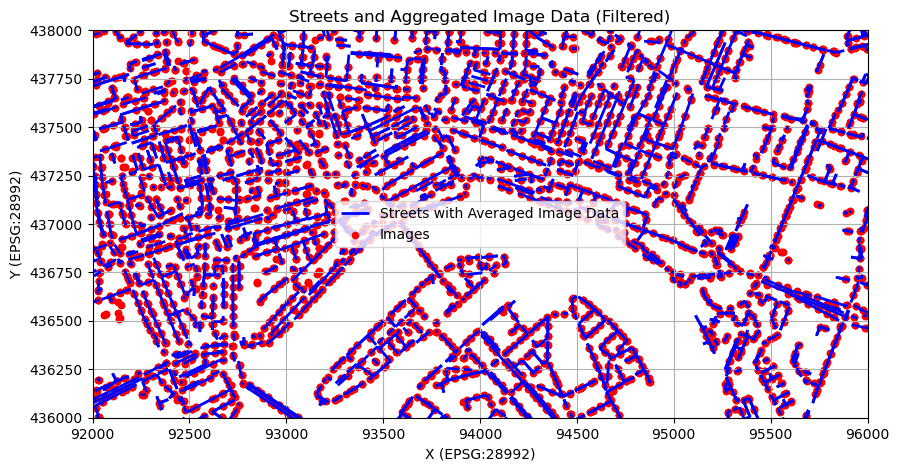

In [12]:
# Visualization of the results
# Define visualization bounds
visualization_bounds = {
    "x_min": 92000,
    "x_max": 96000,
    "y_min": 436000,
    "y_max": 438000
}

# Filter the data for visualization bounds
filtered_visual_streets = final_dataset.cx[visualization_bounds["x_min"]:visualization_bounds["x_max"],
                             visualization_bounds["y_min"]:visualization_bounds["y_max"]]
filtered_visual_images = img_data.cx[visualization_bounds["x_min"]:visualization_bounds["x_max"],
                                visualization_bounds["y_min"]:visualization_bounds["y_max"]]

# Visualization of the results
fig, ax = plt.subplots(figsize=(10, 8))
filtered_visual_streets.plot(ax=ax, color='blue', linewidth=2, label='Streets with Averaged Image Data')
filtered_visual_images.plot(ax=ax, color='red', markersize=20, label='Images')

# Add labels, title, and legend
plt.legend()
plt.title('Streets and Aggregated Image Data (Filtered)')
plt.xlabel('X (EPSG:28992)')
plt.ylabel('Y (EPSG:28992)')
plt.xlim(visualization_bounds["x_min"], visualization_bounds["x_max"])
plt.ylim(visualization_bounds["y_min"], visualization_bounds["y_max"])
plt.grid(True)

# Show the plot
plt.show()

#### **1.4. Exploring the street view images.**
- (a) Explore the distribution of the speed (`speed`) in the dataset built in 1.3. Remove outliers and plot the final distribution: The histogram and a map. In the map, color the streets based on the speed.
- (b) Sample ten street view images (present in the folder, i.e., in_folder == 1) from streets with a speed between 20 and 50 km/h.
- (c) Repeat (b) sampling images from streets with a speed between 0> and 10 km/h.
- (d) Did you see differences in the urban scenery comparing the images from (b) and (c)?

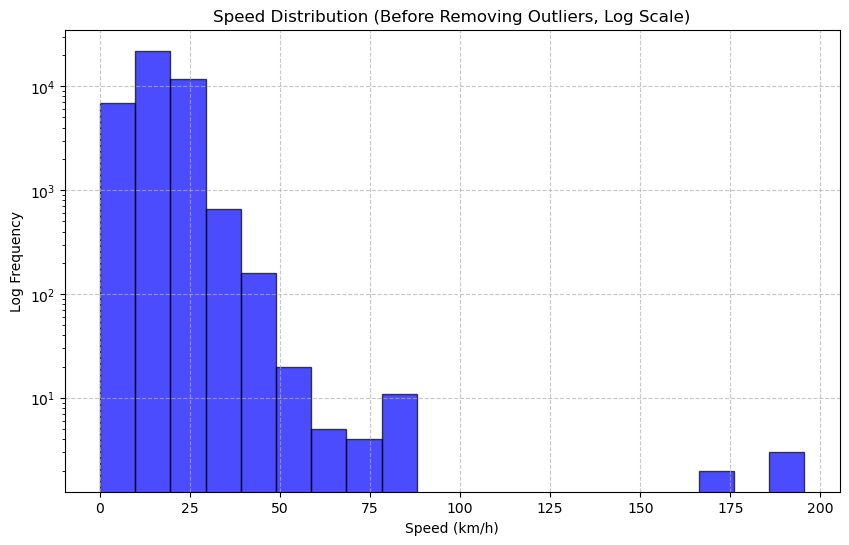

In [13]:
# (a) Explore the distribution of the speed
# Initial plot: Explore the distribution of speed
plt.figure(figsize=(10, 6))
plt.hist(final_dataset['speed'], bins=20, color='blue', alpha=0.7, edgecolor='black', log=True)
plt.title("Speed Distribution (Before Removing Outliers, Log Scale)")
plt.xlabel("Speed (km/h)")
plt.ylabel("Log Frequency")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

This histogram shows bike speed on a logarithmic scale to highlight outliers. Most speeds are below 40 km/h, which is realistic for bikes. However, there are improbable outliers: speeds above 40 km/h and negative speeds, which are physically impossible. These likely result from data errors or misrecordings and should be removed for accurate analysis.

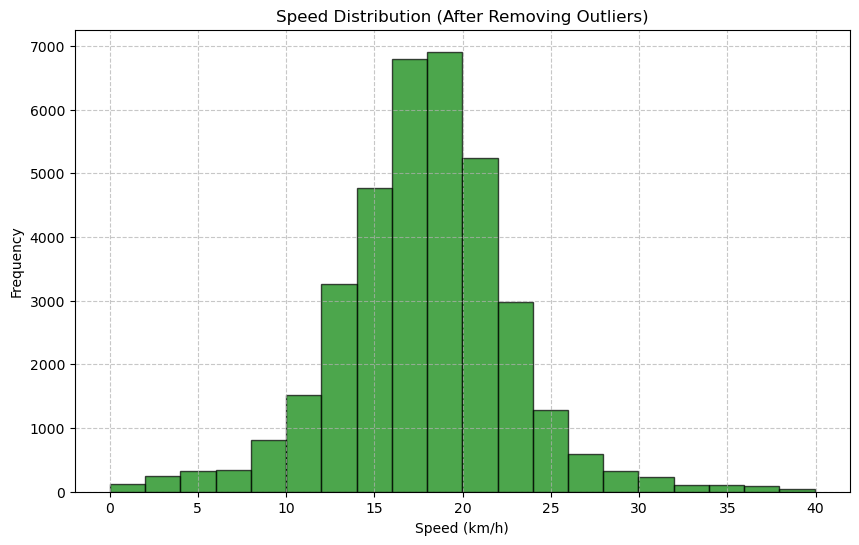

In [14]:
# Define logical thresholds for bike speed
min_speed = 0  # Minimum realistic speed (outside the interval)
max_speed = 40  # Maximum realistic speed    ---> if you're not Ganna or Mark Cavendish

# Remove outliers based on thresholds
filtered_dataset = final_dataset[(final_dataset['speed'] > min_speed) & (final_dataset['speed'] <= max_speed)]

# Plot distribution after removing outliers with log scale
plt.figure(figsize=(10, 6))
plt.hist(filtered_dataset['speed'], bins=20, color='green', alpha=0.7, edgecolor='black')
plt.title("Speed Distribution (After Removing Outliers)")
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


This histogram shows the bike speed distribution after removing outliers. The speeds now range between 0 and 40 km/h, reflecting realistic biking conditions. Most speeds are concentrated between 10 and 25 km/h, which is typical for urban and recreational cycling. The data is now cleaner and better suited for modeling and analysis.

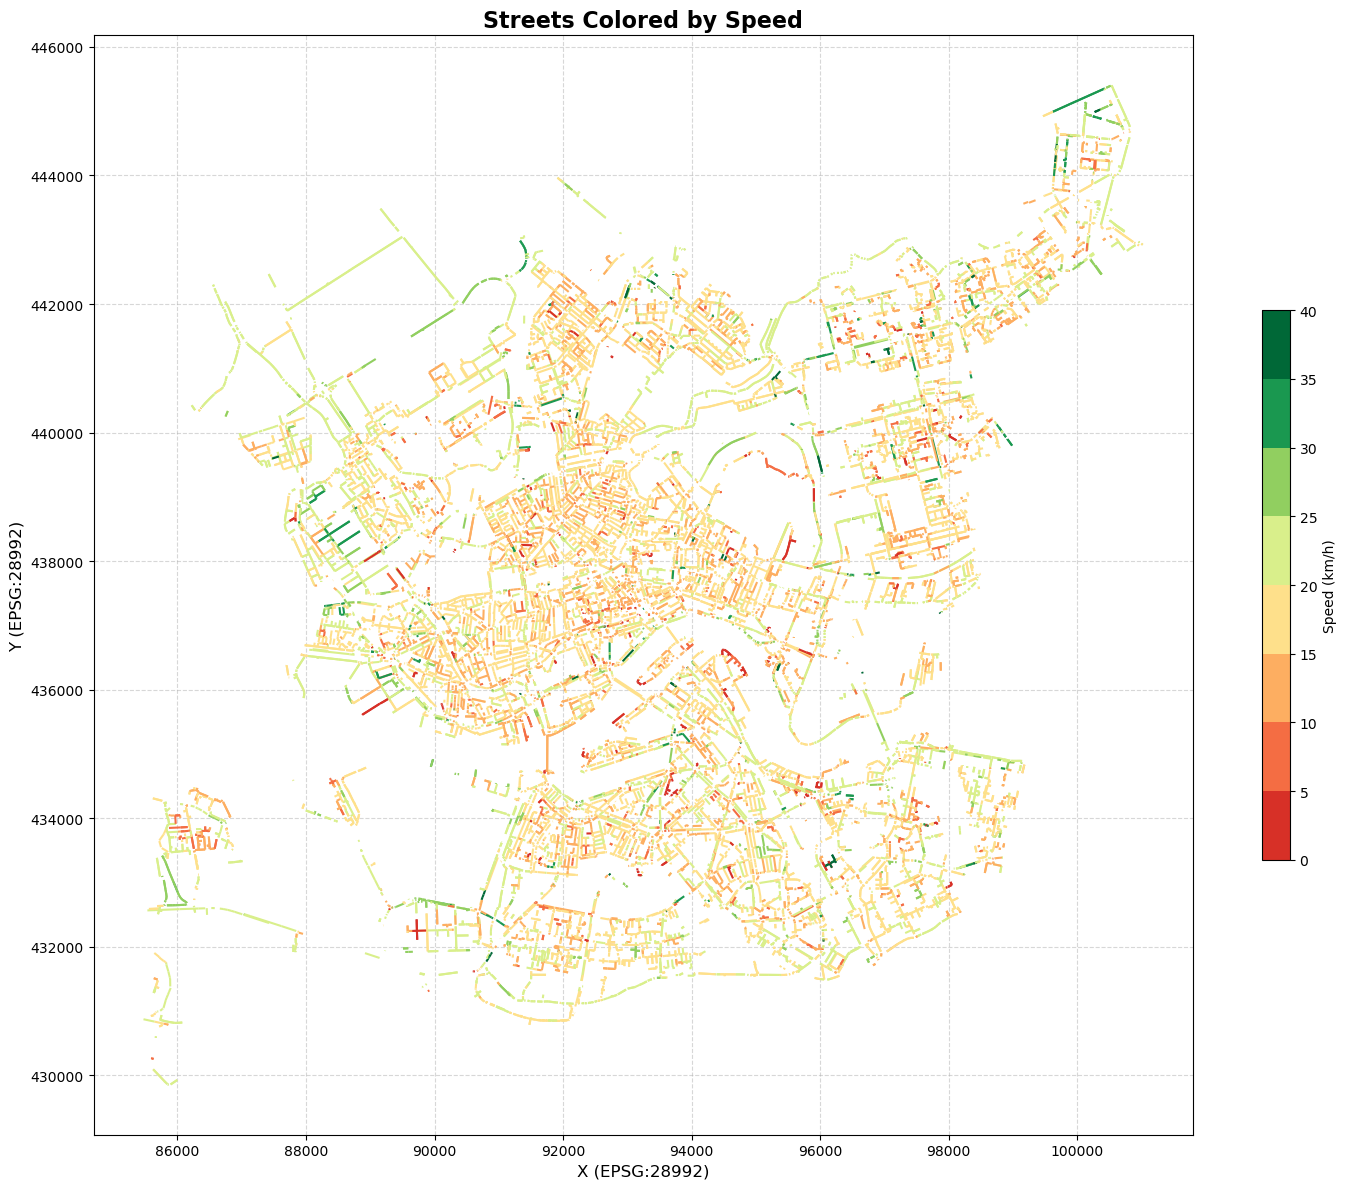

In [15]:
import matplotlib.colors as mcolors

# Define the bins and corresponding colors for the discrete colormap
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]  # Define speed intervals
colors = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850', '#006837']  # 8 colors for 8 bins
cmap = mcolors.ListedColormap(colors)  # Create discrete colormap
norm = mcolors.BoundaryNorm(boundaries=bins, ncolors=len(colors))  # Match number of bins to colors

# Plot a map to visualize streets colored by speed
fig, ax = plt.subplots(figsize=(15, 12))

# Plotting streets colored by speed using the discrete colormap
streets = filtered_dataset.plot(
    ax=ax,
    column='speed',
    cmap=cmap,  # Apply the discrete colormap
    norm=norm,  # Apply normalization for the bins
    legend=True,
    legend_kwds={
        'shrink': 0.5,  # Shrink the legend size
        'label': "Speed (km/h)",  # Add a label to the legend
        'ticks': bins,  # Show ticks for each bin in the legend
        'spacing': 'proportional'  # Make legend spacing proportional
    }
)

# Add title and labels
plt.title("Streets Colored by Speed", fontsize=16, weight='bold')
plt.xlabel("X (EPSG:28992)", fontsize=12)
plt.ylabel("Y (EPSG:28992)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

This map shows bike speeds across Rotterdam, with colors from red (0 km/h) to green (40 km/h). Higher speeds are mostly found in open areas, while lower speeds appear in busy residential or urban streets. Long streets and periferic streets have higher speeds, while super small streets inside busy neighbourouds have speed closer to zero, red areas. 

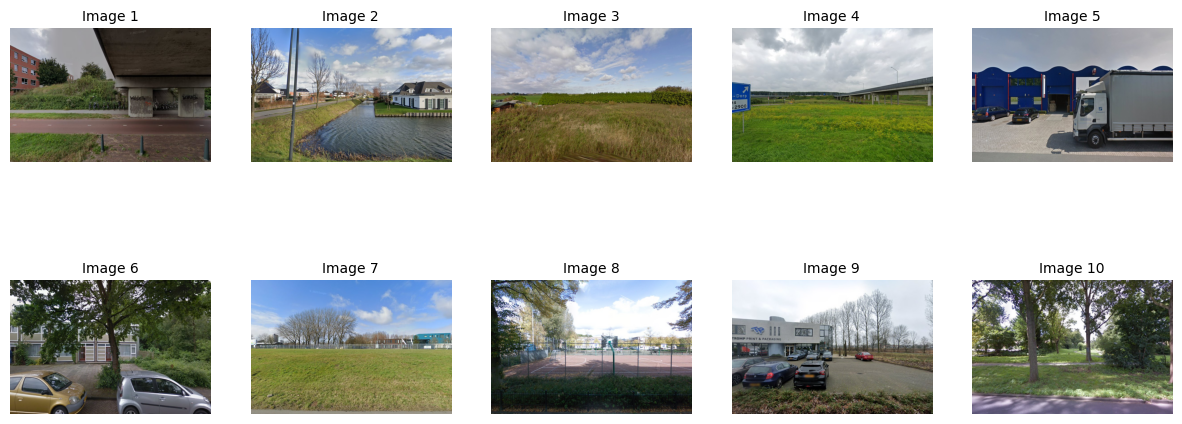

In [16]:
#(b) Sample ten street view images (present in the folder, i.e., in_folder == 1) from streets with a speed between 20 and 50 km/h.
from PIL import Image  # Import Pillow for image handling
import os  # For joining paths

# Base directory for the images
base_dir = "data/images/"


# Filter the dataset for the required conditions
filtered_streets = street_images[
    (street_images['speed'] >= 20) &  # Speed greater than or equal to 20
    (street_images['speed'] <= 50) &  # Speed less than or equal to 50
    (street_images['in_folder'] == 1)  # Only streets in the folder
]

# Randomly sample 10 records
sampled_images = filtered_streets.sample(n=10, random_state=34)

# Plot each image in a grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten axes for easy indexing

for i, (img_path, ax) in enumerate(zip(sampled_images['img_path'], axes)):
    full_path = os.path.join(base_dir, img_path)  # Add the base directory to the image path
    try:
        # Read and display the image using Pillow
        img = Image.open(full_path)
        ax.imshow(img)
        ax.axis("off")  # Hide axes
        ax.set_title(f"Image {i + 1}", fontsize=10)
    except (FileNotFoundError, OSError):
        # Handle missing or unreadable files
        ax.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=12)
        ax.axis("off")



The majority of the images in this sample, corresponding to streets with higher speeds, represent open spaces and nature rather than residential areas. Despite not having direct views of the streets in most cases, we can hypothesize that open environments with fewer obstacles and less traffic likely contribute to the higher bike speeds observed in these areas.

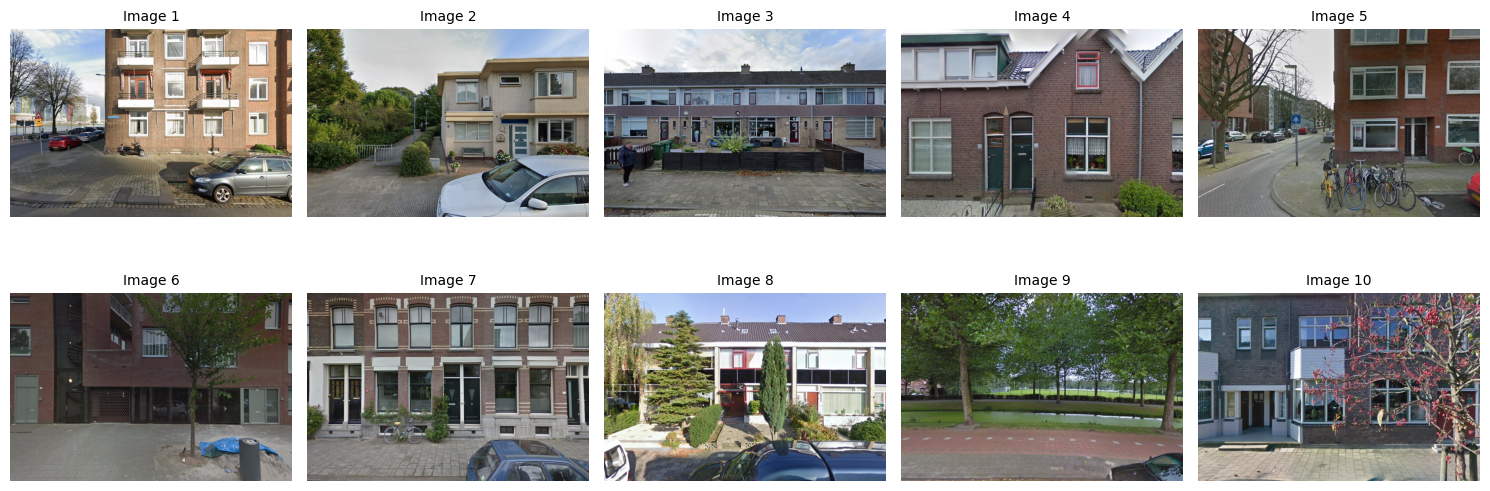

In [17]:
#(c) Repeat (b) sampling images from streets with a speed between 0> and 10 km/h.
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image  # Import Pillow for image handling
import os  # For joining paths

# Base directory for the images
base_dir = "data/images/"

# Filter the dataset for streets with speeds between 0 and 10 km/h and in_folder == 1
filtered_streets2 = street_images[
    (street_images['speed'] > 0) &  # Speed greater than 0
    (street_images['speed'] <= 10) &  # Speed less than or equal to 10
    (street_images['in_folder'] == 1)  # Only streets in the folder
]

# Randomly sample 10 records
sampled_images = filtered_streets2.sample(n=10, random_state=36)

# Plot each image in a grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten axes for easy indexing

for i, (img_path, ax) in enumerate(zip(sampled_images['img_path'], axes)):
    full_path = os.path.join(base_dir, img_path)  # Add the base directory to the image path
    try:
        # Read and display the image using Pillow
        img = Image.open(full_path)
        ax.imshow(img)
        ax.axis("off")  # Hide axes
        ax.set_title(f"Image {i + 1}", fontsize=10)
    except (FileNotFoundError, OSError):
        # Handle missing or unreadable files
        ax.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=12)
        ax.axis("off")

plt.tight_layout()
plt.show()


In this case, most of the images show houses and residential areas, representing streets where bike speeds are under 10 km/h. These areas often have more things like parked cars, narrower paths, or other features that make cyclists ride more slowly.

### **2. Model training**. Train different machine learning models for predicting the bike speed based on the embedding characteristics. 

#### **2.1. Dataset for training**. Prepare the dataset for the modelling. 
- (a) Keep only the relevant columns for the training phase: embedding columns and bike speed.
- (b) Split the dataset train/test using two different approaches:
    - (b.1) Random-based: Split 80%/20% randomly.
    - (b.2) Location-based: Split 80%/20% geographically. Create a buffer around a coordinate to select 20% of the data points as test set (taking all datapoints inside the buffer).
- (c) Plot in a map both approaches. Using blue for coloring the streets in the training set and red for the test set.

In [18]:
#(a) Keep only the relevant columns for the training phase: from filtered_streets I keep only embedding columns and bike speed

# Define the columns to keep
columns_to_keep = ['speed', 'geometry'] + embedding_columns

# Filter the dataset
Model_dataset = filtered_dataset[columns_to_keep]

#(b) Split the dataset
#(b.1) Random-based

train_data_random, test_data_random = train_test_split(Model_dataset, test_size=0.2, random_state=42)


#(b.2) Location-based: Split 80%/20% geographically


# Define central coordinate and initial radius      [intervals x-axis [85000, 110000], y-axis [4300000,4460000]
central_x, central_y = 90000, 440000
buffer_center = Point(central_x, central_y)
buffer_center = gpd.GeoDataFrame(geometry=[buffer_center], crs=Model_dataset.crs)


# Function for geographic split
def get_test_set(dataset, center, initial_radius, target_ratio=0.2, tolerance=0.01):
    radius = initial_radius
    while True:
        # Create buffer area
        buffer_area = center.buffer(radius)

        # Select streets within the buffer
        streets_in_buffer = dataset[dataset.geometry.intersects(buffer_area.iloc[0])]
        
        # Calculate ratio
        ratio = len(streets_in_buffer) / len(dataset)
        
        # Adjust buffer radius dynamically
        if abs(ratio - target_ratio) <= tolerance:
            return streets_in_buffer, radius
        elif ratio < target_ratio:
            radius *= 1.1  # Increase radius
        else:
            radius *= 0.9  # Decrease radius

# Initial radius
buffer_radius = 500

# Apply the function to split dataset
test_streets_geo, final_radius = get_test_set(Model_dataset, buffer_center, buffer_radius)

# Select train streets (remaining streets)
train_streets_geo = Model_dataset[~Model_dataset.index.isin(test_streets_geo.index)]

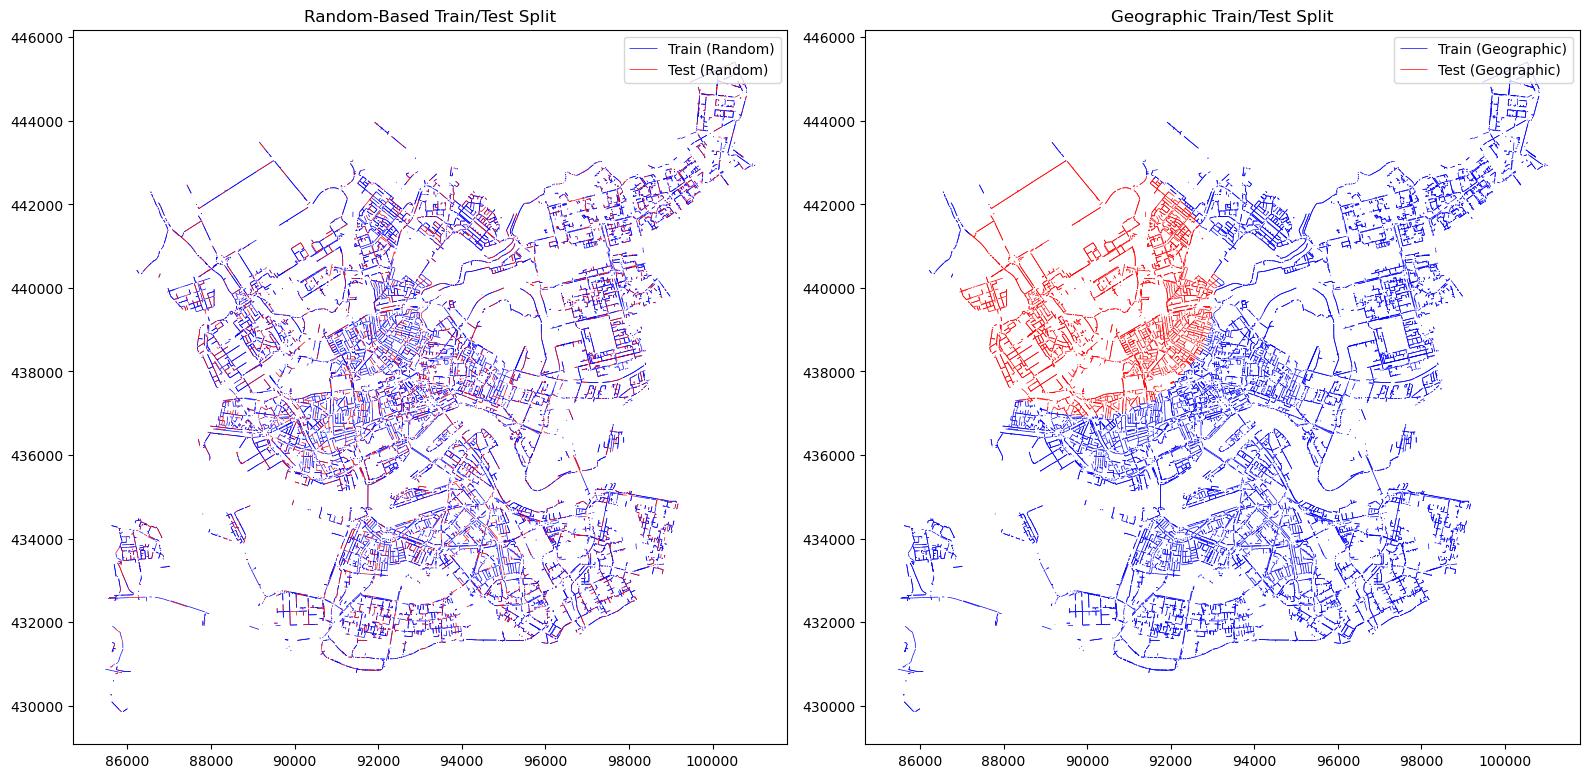

In [19]:
#(c) Plot in a map both approaches
# Plot the random-based and geographic-based train/test splits
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

train_data_random.plot(ax=ax[0], color='blue', label='Train (Random)', linewidth=0.5)
test_data_random.plot(ax=ax[0], color='red', label='Test (Random)', linewidth=0.5)
ax[0].set_title("Random-Based Train/Test Split")
ax[0].legend()

# Geographic-based split visualization
train_streets_geo.plot(ax=ax[1], color='blue', label='Train (Geographic)', linewidth=0.5)
test_streets_geo.plot(ax=ax[1], color='red', label='Test (Geographic)', linewidth=0.5)
ax[1].set_title("Geographic Train/Test Split")
ax[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [20]:
#Drop the geometry column to train the model

# Drop the geometry column from the random train and test sets
train_random = train_data_random.drop(columns=['geometry'])
test_random = test_data_random.drop(columns=['geometry'])


# Drop the geometry column from the train and test sets
train_geo = train_streets_geo.drop(columns=['geometry'])
test_geo = test_streets_geo.drop(columns=['geometry'])


#### **2.2. Training a Linear Regression (LR)** Train a LR for predicting the bike speed using both splits separately. Report the R2 and the MSE for train and test in both cases.

In [21]:
# Define a function to train a Linear Regression model and report metrics

def train_and_evaluate_lr(train, test, target_column):
    # Separate features (X) and target (y)
    X_train = train.drop(columns = target_column)
    y_train = train[target_column]
    X_test = test.drop(columns = target_column)
    y_test = test[target_column]

    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate R² and MSE for train set
    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)

    # Calculate R² and MSE for test set
    r2_test = r2_score(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Print the results
    print("Linear Regression Results:")
    print(f"Train R²: {r2_train:.4f}, Train MSE: {mse_train:.4f}")
    print(f"Test R²: {r2_test:.4f}, Test MSE: {mse_test:.4f}")
    return model, (r2_train, mse_train, r2_test, mse_test)

# Target column for prediction (replace 'speed' with the actual target column name if different)
target_column = 'speed'

# Train and evaluate for the random split
print("\nRandom Split Results:")
lr_random, metrics_random = train_and_evaluate_lr(train_random, test_random, 'speed')

# Train and evaluate for the geographic split
print("\nGeographic Split Results:")
lr_geo, metrics_geo = train_and_evaluate_lr(train_geo, test_geo, target_column)



Random Split Results:
Linear Regression Results:
Train R²: 0.0785, Train MSE: 22.2587
Test R²: 0.0771, Test MSE: 21.7219

Geographic Split Results:
Linear Regression Results:
Train R²: 0.0775, Train MSE: 22.7697
Test R²: 0.0684, Test MSE: 19.6620


#### **2.3. Training a Random Forest (RF)**. Train a RF for predicting the bike speed using both splits separately. Report the R2 and the MSE for train and test in both cases. Hyperameter tunning is NOT needed in this task.

In [22]:
# Define a function to train and evaluate a Random Forest model

def train_and_evaluate_rf(train, test, target_column):
    # Separate features (X) and target (y)
    X_train = train.drop(columns=[target_column])
    y_train = train[target_column]
    X_test = test.drop(columns=[target_column])
    y_test = test[target_column]

    # Initialize and train the Random Forest model
    rf_model = RandomForestRegressor(random_state=42)  # Set random_state for reproducibility
    rf_model.fit(X_train, y_train)

    # Predict on train and test sets
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)

    # Calculate R² and MSE for train and test sets
    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Report results
    print("Random Forest Results:")
    print(f"Train R²: {r2_train:.4f}, Train MSE: {mse_train:.4f}")
    print(f"Test R²: {r2_test:.4f}, Test MSE: {mse_test:.4f}")

    return rf_model, (r2_train, mse_train, r2_test, mse_test)

# Target column for prediction (replace 'speed' with the actual target column name if different)
target_column = 'speed'

# Train and evaluate for the random split
print("\nRandom Split Results:")
rf_random, metrics_random = train_and_evaluate_rf(train_random, test_random, target_column)

# Train and evaluate for the geographic split
print("\nGeographic Split Results:")
rf_geo, metrics_geo = train_and_evaluate_rf(train_geo, test_geo, target_column)



Random Split Results:
Random Forest Results:
Train R²: 0.8577, Train MSE: 3.4361
Test R²: 0.5121, Test MSE: 11.4840

Geographic Split Results:
Random Forest Results:
Train R²: 0.8519, Train MSE: 3.6552
Test R²: 0.0671, Test MSE: 19.6892


#### **2.4. Training a Multi-Layer Perceptron (MLP)**. Train a MLP for predicting the bike speed using both splits separately. Report the R2 and the MSE for train and test in both cases. Hyperameter tunning is NOT needed in this task.

In [23]:
# Define a function to train and evaluate an MLP model
def train_and_evaluate_mlp(train, test, target_column):
    # Separate features (X) and target (y)
    X_train = train.drop(columns=[target_column])
    y_train = train[target_column]
    X_test = test.drop(columns=[target_column])
    y_test = test[target_column]

    # Initialize and train the MLP model
    mlp_model = MLPRegressor(random_state=42, max_iter=5000)  # Set random_state for reproducibility
    mlp_model.fit(X_train, y_train)

    # Predict on train and test sets
    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    # Calculate R² and MSE for train and test sets
    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Report results
    print("Multi-Layer Perceptron Results:")
    print(f"Train R²: {r2_train:.4f}, Train MSE: {mse_train:.4f}")
    print(f"Test R²: {r2_test:.4f}, Test MSE: {mse_test:.4f}")

    return mlp_model, (r2_train, mse_train, r2_test, mse_test)

# Target column for prediction (replace 'speed' with the actual target column name if different)
target_column = 'speed'

# Train and evaluate for the random split
print("\nRandom Split Results:")
mlp_random, metrics_random = train_and_evaluate_mlp(train_random, test_random, target_column)

# Train and evaluate for the geographic split
print("\nGeographic Split Results:")
mlp_geo, metrics_geo = train_and_evaluate_mlp(train_geo, test_geo, target_column)



Random Split Results:
Multi-Layer Perceptron Results:
Train R²: 0.3408, Train MSE: 15.9240
Test R²: 0.1849, Test MSE: 19.1841

Geographic Split Results:
Multi-Layer Perceptron Results:
Train R²: 0.3676, Train MSE: 15.6083
Test R²: -0.1392, Test MSE: 24.0431


### **3. Model selection and application**
#### **3.1. Reflexion data splits**. Reflect on the model indicators
- (a) Did you see difference between the splits? If so, what could cause those differences?
- (b) Which of these two splits do you think it is more robust? why?

# Updated Model Performance Descriptions

### **Random Split (Linear Regression):**
Linear regression yields a low \( R^2 \) (0.0771) and high MSE (21.7219) on the test set, indicating poor performance. The model struggles to capture meaningful relationships between features and bike speed, even with balanced data.

### **Geographic Split (Linear Regression):**
The performance in the geographic split is similarly poor, with a slight improvement in test \( R^2 \) (0.0684) and reduced test MSE (19.6620). However, the model remains unable to generalize effectively, reinforcing its limitations in capturing complex relationships.

---

### **Random Split (Random Forest):**
Random forest achieves a relatively high test \( R^2 \) (0.5121) and lower MSE (11.4840) compared to other models. This demonstrates its capability to model non-linear relationships and deliver robust predictions when the training and test data share similar distributions.

### **Geographic Split (Random Forest):**
The test \( R^2 \) drops substantially (0.0671), and the test MSE increases (19.6892) in the geographic split. This reflects the model's reliance on interpolating within known data, with reduced effectiveness in generalizing to unseen geographic regions.

---

### **Random Split (MLP):**
The MLP model shows moderate performance with a test \( R^2 \) of 0.1849 and an MSE of 19.1841. While it outperforms linear regression, it falls short of random forest, highlighting its moderate ability to model relationships in random splits.

### **Geographic Split (MLP):**
Performance drops drastically in the geographic split, with a negative test \( R^2 \) (-0.1392) and high MSE (24.0431). This highlights the model's tendency to overfit the training data and its difficulty in generalizing to new, unseen regions.

---

## Reflections on Data Splits

### **(a)**
The updated results confirm significant performance differences between random and geographic splits. Models perform better with random splits due to shared distributions between training and test sets, while performance declines with geographic splits, emphasizing generalization challenges.

### **(b)**
The geographic split remains more robust for evaluating real-world applicability. Although it poses challenges, it provides a realistic assessment of model performance when predicting in new geographic areas, making it a more rigorous test for generalization.


#### **3.2. Model selection and application**. 
- (a) Choose a model for its application and justify the choice.
- (b) Apply the selected model and plot the predicted values and the errors in two different maps.

(a) Random forest is the preferred model because it consistently achieves better \(R^2\) and MSE across splits, capturing non-linear relationships effectively. It is also less prone to overfitting compared to the MLP and offers interpretability through feature importance analysis. I decide to keep both the splits, and analyze also how they differ in the predictions, even if the random split should be the one more adapt to the task.


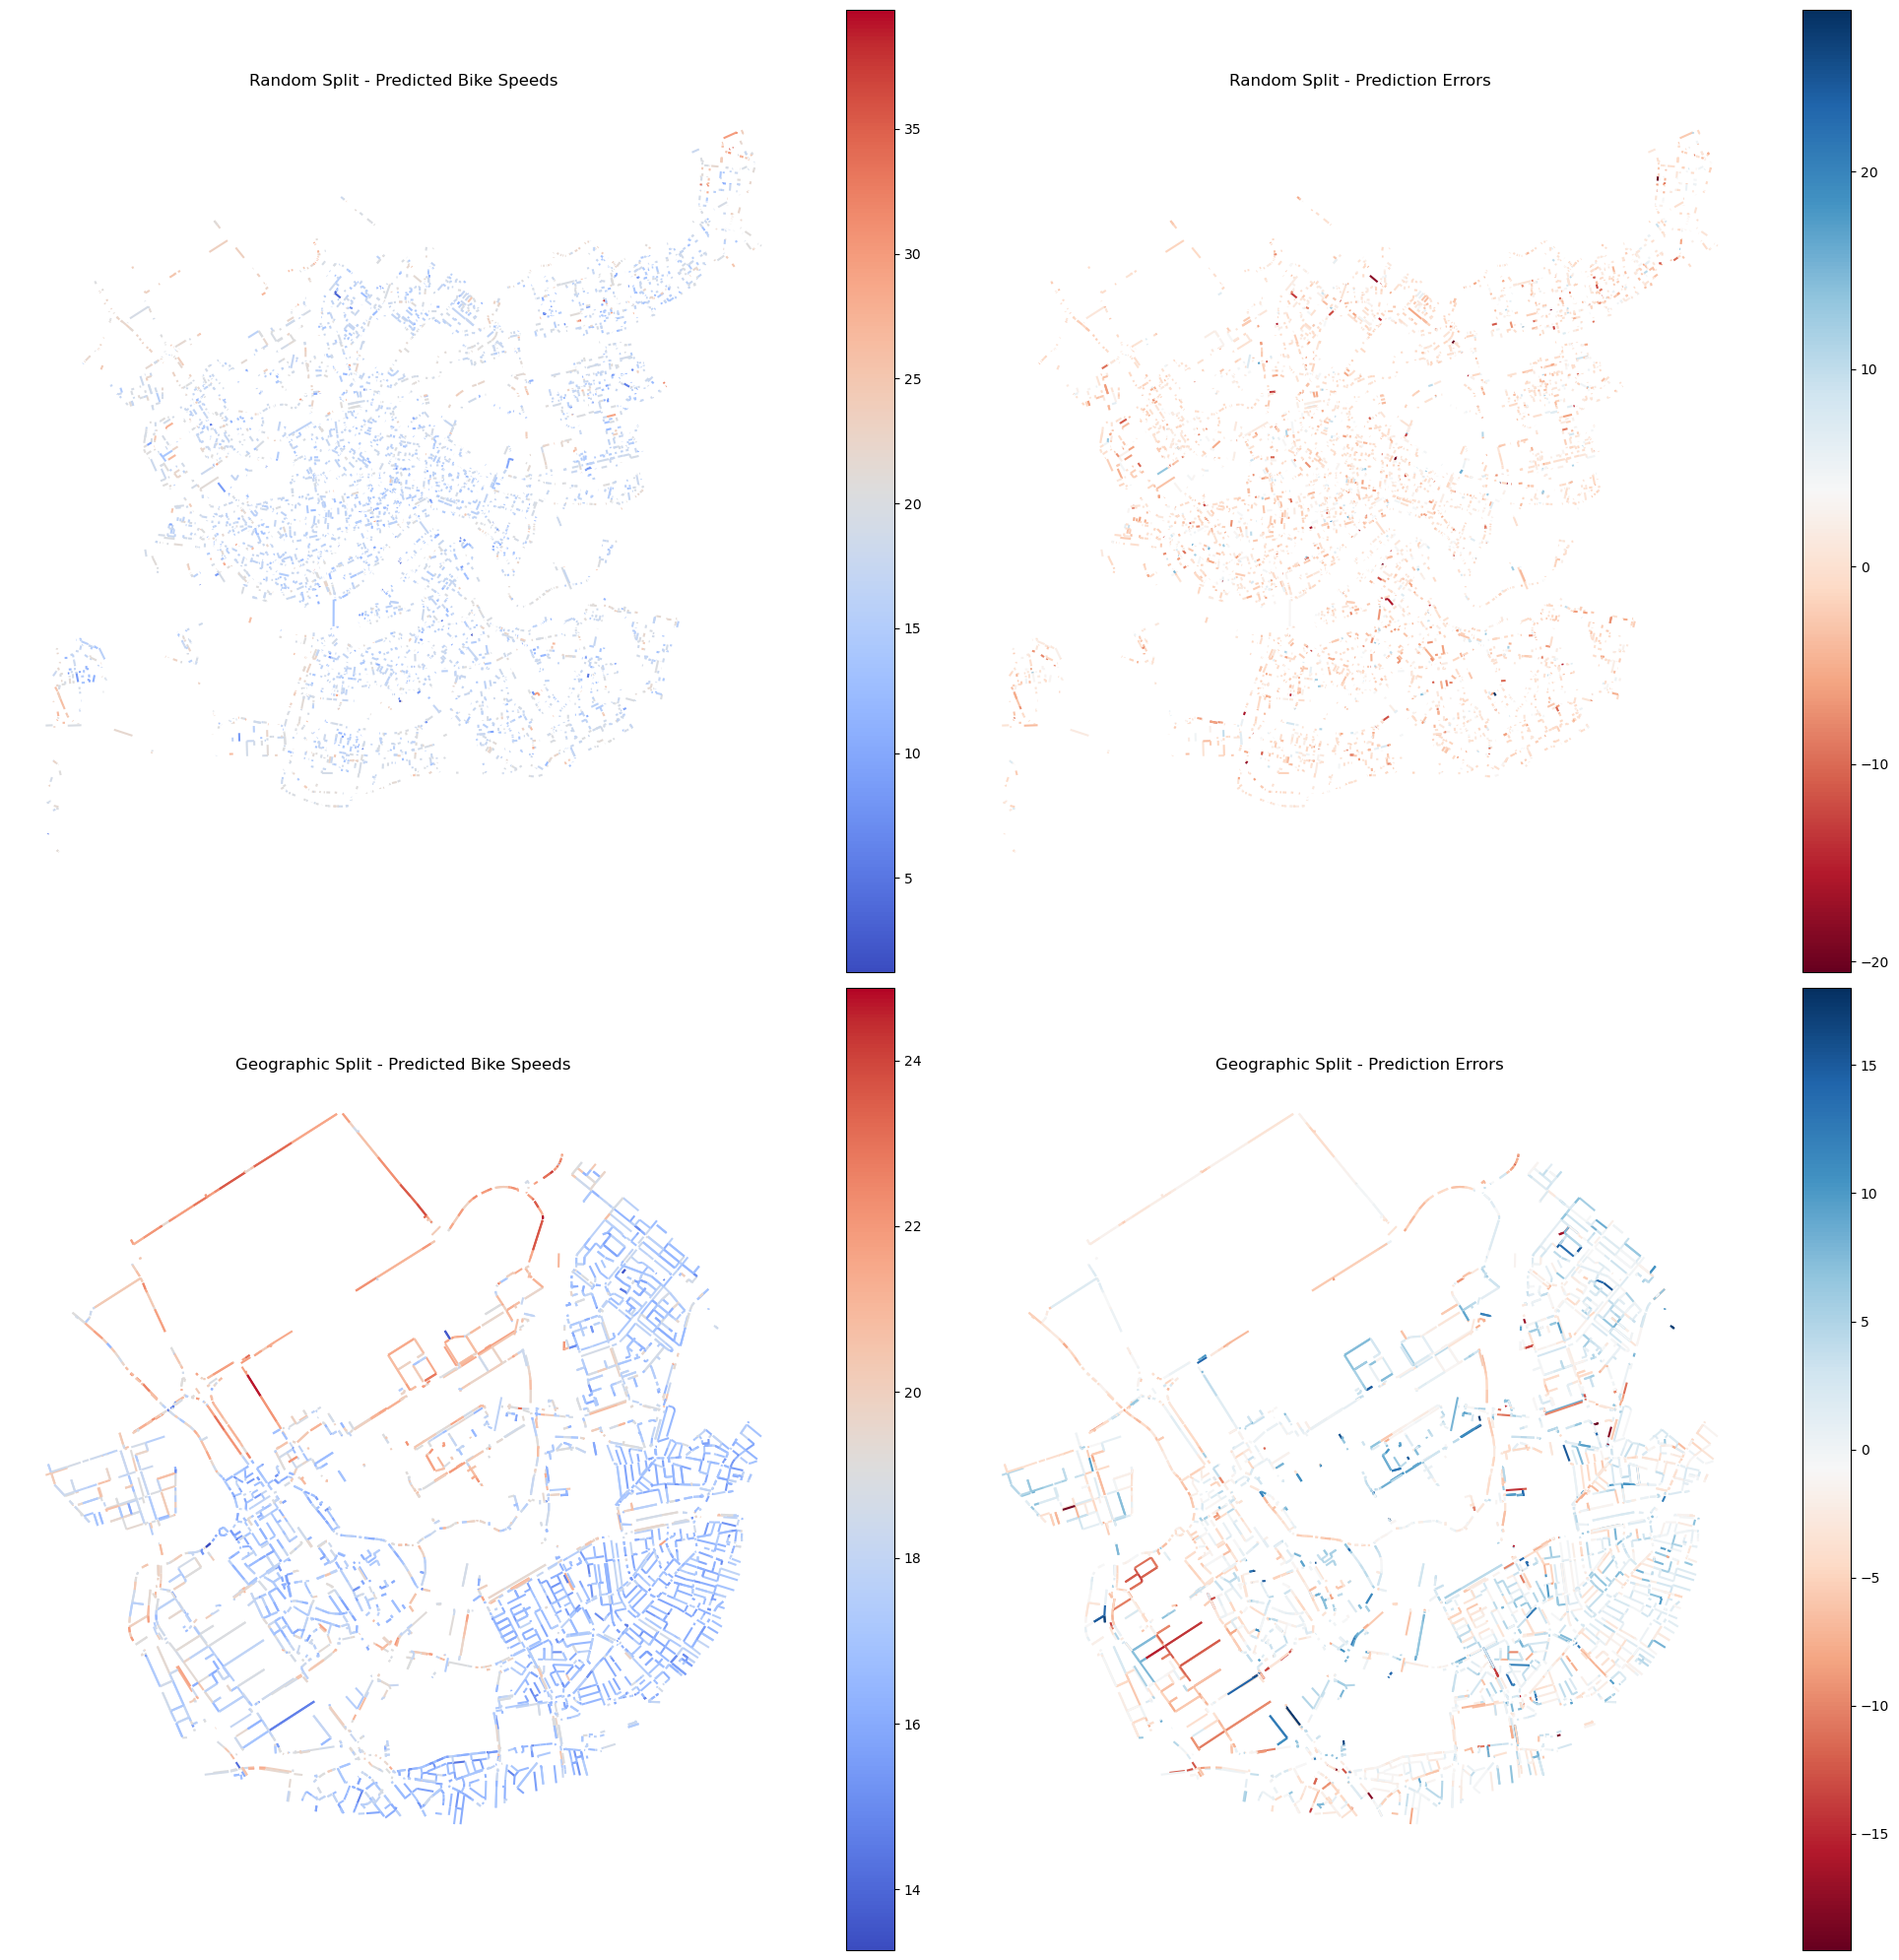

In [48]:
# Add predictions and errors to the GeoDataFrames
test_data_random.loc[:, 'predicted_speed'] = rf_random.predict(test_random.drop(columns=[target_column]))
test_data_random.loc[:, 'error'] = test_data_random['predicted_speed'] - test_data_random[target_column]

test_streets_geo.loc[:, 'predicted_speed'] = rf_geo.predict(test_geo.drop(columns=[target_column]))
test_streets_geo.loc[:, 'error'] = test_streets_geo['predicted_speed'] - test_streets_geo[target_column]

# Plot maps
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

# Random split - Predicted Speeds
test_data_random.plot(column='predicted_speed', cmap='coolwarm', legend=True, ax=ax[0, 0], markersize=5)
ax[0, 0].set_title("Random Split - Predicted Bike Speeds")
ax[0, 0].set_axis_off()

# Random split - Errors
test_data_random.plot(column='error', cmap='RdBu', legend=True, ax=ax[0, 1], markersize=5)
ax[0, 1].set_title("Random Split - Prediction Errors")
ax[0, 1].set_axis_off()

# Geographic split - Predicted Speeds
test_streets_geo.plot(column='predicted_speed', cmap='coolwarm', legend=True, ax=ax[1, 0], markersize=5)
ax[1, 0].set_title("Geographic Split - Predicted Bike Speeds")
ax[1, 0].set_axis_off()

# Geographic split - Errors
test_streets_geo.plot(column='error', cmap='RdBu', legend=True, ax=ax[1, 1], markersize=5)
ax[1, 1].set_title("Geographic Split - Prediction Errors")
ax[1, 1].set_axis_off()

plt.tight_layout()
plt.show()


**Top-Left Plot: Random Split - Predicted Bike Speeds**

Predicted bike speeds are more uniformly distributed, with less pronounced clustering compared to the geographic split.  
Higher speeds (red) appear scattered across various regions rather than concentrated in urban centers.  
The uniformity shows that the random split model generalizes predictions without strong spatial biases.  
This approach reduces overfitting to specific areas but may miss local trends.  
The lack of clustering reflects the model’s focus on overall feature distributions rather than spatial relationships.  

**Top-Right Plot: Random Split - Prediction Errors**

Prediction errors are scattered across the map without clear spatial patterns, suggesting a more generalized performance.  
Overestimations (red) and underestimations (blue) occur randomly, with no apparent dependence on geographic location.  
This even distribution indicates that the model does not overfit to specific regions.  
However, the lack of spatial clustering might reflect an inability to capture local variations.  
The random split model performs more consistently but sacrifices spatial sensitivity.  

**Bottom-Left Plot: Geographic Split - Predicted Bike Speeds**

Predicted bike speeds show clear spatial clustering, with higher speeds (red) in central regions and lower speeds (blue) in peripheral areas.  
Urban areas with denser road networks are associated with higher predicted speeds, while sparsely connected roads see lower values.  
The clustering indicates the model captures local spatial trends well.  
However, it also suggests the model's predictions rely heavily on spatial proximity.  
This pattern highlights the geographic split model’s focus on localized spatial relationships.  

**Bottom-Right Plot: Geographic Split - Prediction Errors**

Prediction errors in the geographic split are spatially concentrated, with certain regions consistently overestimated (red) or underestimated (blue).  
Peripheral areas show larger errors, likely due to fewer data points in those locations.  
Urban centers with dense road networks tend to have smaller errors, indicating stronger model performance in data-rich areas.  
The error clustering suggests challenges in generalizing to distinct regions.  
These patterns may reflect unbalanced data or missing regional variables.  



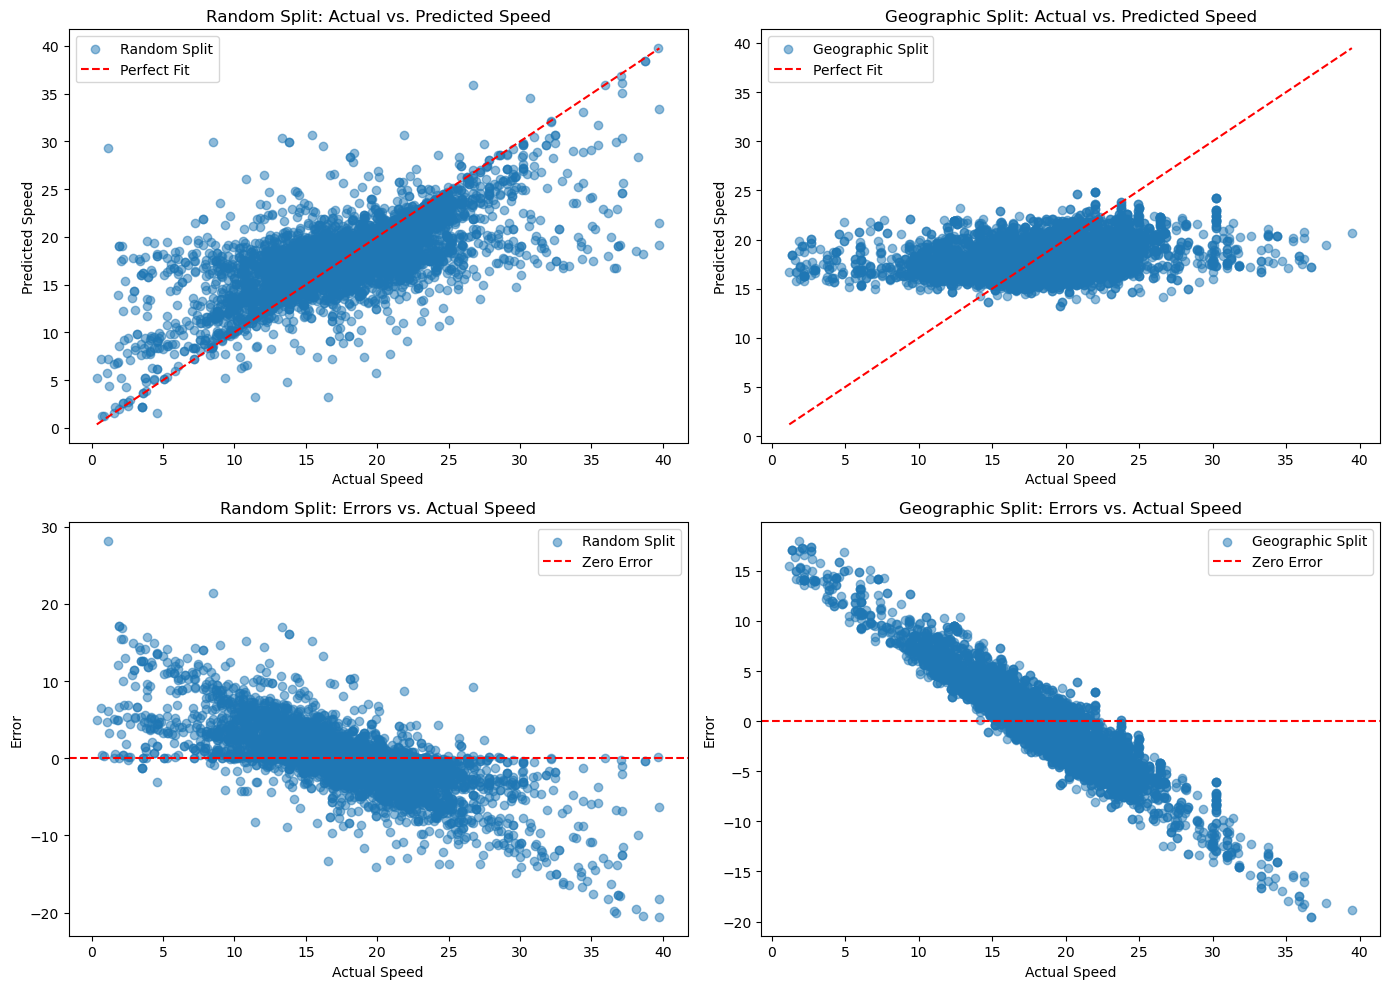

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Create a 2x2 grid of subplots

# Scatter Plot: Actual Speed vs. Predicted Speed (Random Split)
axs[0, 0].scatter(test_data_random[target_column], test_data_random['predicted_speed'], alpha=0.5, label="Random Split")
axs[0, 0].plot([test_data_random[target_column].min(), test_data_random[target_column].max()], 
               [test_data_random[target_column].min(), test_data_random[target_column].max()], 
               color='red', linestyle='--', label='Perfect Fit')
axs[0, 0].set_xlabel('Actual Speed')
axs[0, 0].set_ylabel('Predicted Speed')
axs[0, 0].set_title("Random Split: Actual vs. Predicted Speed")
axs[0, 0].legend()

# Scatter Plot: Actual Speed vs. Predicted Speed (Geographic Split)
axs[0, 1].scatter(test_streets_geo[target_column], test_streets_geo['predicted_speed'], alpha=0.5, label="Geographic Split")
axs[0, 1].plot([test_streets_geo[target_column].min(), test_streets_geo[target_column].max()], 
               [test_streets_geo[target_column].min(), test_streets_geo[target_column].max()], 
               color='red', linestyle='--', label='Perfect Fit')
axs[0, 1].set_xlabel('Actual Speed')
axs[0, 1].set_ylabel('Predicted Speed')
axs[0, 1].set_title("Geographic Split: Actual vs. Predicted Speed")
axs[0, 1].legend()

# Scatter Plot: Actual Speed vs. Errors (Random Split)
axs[1, 0].scatter(test_data_random[target_column], test_data_random['error'], alpha=0.5, label="Random Split")
axs[1, 0].axhline(0, color='red', linestyle='--', label='Zero Error')
axs[1, 0].set_xlabel('Actual Speed')
axs[1, 0].set_ylabel('Error')
axs[1, 0].set_title("Random Split: Errors vs. Actual Speed")
axs[1, 0].legend()

# Scatter Plot: Actual Speed vs. Errors (Geographic Split)
axs[1, 1].scatter(test_streets_geo[target_column], test_streets_geo['error'], alpha=0.5, label="Geographic Split")
axs[1, 1].axhline(0, color='red', linestyle='--', label='Zero Error')
axs[1, 1].set_xlabel('Actual Speed')
axs[1, 1].set_ylabel('Error')
axs[1, 1].set_title("Geographic Split: Errors vs. Actual Speed")
axs[1, 1].legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


Analyzing the results, without the spatial component, it is possible to conclude:

- **Random split:** With a random split of the data, the model demonstrated a reasonable level of predictive capability. The predicted speeds generally followed the actual speeds, although some variance around the ideal prediction line was observed. Prediction errors were somewhat randomly distributed, with a slight bias toward overestimation.

- **Geographic results:** The model's performance with the geographic data split was significantly flawed. It displayed a strong bias by predicting speeds within a narrow range, regardless of the actual speeds. The prediction errors were negatively correlated with the actual speeds; slower bikes tended to be overestimated, while faster bikes tended to be underestimated.
Conclusion

The results indicate that the random split provides a model that better fits the data, while the geographic split method reveals that the model did not generalize well to data with different geographic characteristics. This highlights how poor is the choice of the geographic split in generalization.

## Part II: Explainable AI
### **1. Data preparation and exploration**
#### **1.1. Loading datasets.** Load the datasets from the folder traffic_accidents. Explore them with `df.head()` for you to familiarize with the tables.

In [26]:
traffic_accidents = pd.read_csv("data/traffic_accidents/accident_parties.csv",dtype={'VEHICLE_POS': str})
traffic_accidents.head()

PARTIE_ID  ACCIDENT_ID             VEHICLE           VEHICLE_POS
0   25909704  20140010014          Bestelauto               Rijbaan
1   25909705  20140010014               Fiets               Rijbaan
2   25909706  20140010030        Personenauto               Rijbaan
3   25909707  20140010030           Bromfiets  Fietspad/fietsstrook
4   25909708  20140010030  Overig vast object         Trottoir/berm

In [27]:
accident_events = gpd.read_file("data/traffic_accidents/accident_events.geojson")
accident_events.head(30)

ACCIDENT_ID  YEAR  N_PARTIES                   AP3 ACCIDENT_NATURE  \
0   20140140003  2014          2  Only material damage         Unknown   
1   20140140004  2014          1  Only material damage          Single   
2   20140140005  2014          2  Only material damage          Single   
3   20140140007  2014          2  Only material damage         Unknown   
4   20140140008  2014          3  Only material damage         Unknown   
5   20140140009  2014          3  Only material damage         Unknown   
6   20140141208  2014          1  Only material damage          Single   
7   20140141210  2014          2                Injury         Unknown   
8   20140141211  2014          2  Only material damage         Unknown   
9   20140141212  2014          2                Injury          Single   
10  20140141215  2014          2  Only material damage         Unknown   
11  20140141645  2014          2  Only material damage         Unknown   
12  20140141649  2014          2                Injury         Unknown   
13  20140141650  2014          2  Only material damage         Unknown   
14  20140141651  2014          2  Only material damage         Unknown   
15  20140141663  2014          2  Only material damage         Unknown   
16  20140141665  2014          2  Only material damage          Single   
17  20140141669  2014          2  Only material damage         Unknown   
18  20140141672  2014          3  Only material damage         Unknown   
19  20140141673  2014          2  Only material damage          Single   
20  20140141674  2014          2  Only material damage         Unknown   
21  20140141675  2014          2  Only material damage         Unknown   
22  20140141676  2014          2  Only material damage         Unknown   
23  20149028657  2014          0  Only material damage         Unknown   
24  20149028659  2014          0  Only material damage         Unknown   
25  20149028680  2014          0  Only material damage         Unknown   
26  20149028684  2014          0  Only material damage         Unknown   
27  20149028685  2014          0  Only material damage         Unknown   
28  20149028689  2014          0  Only material damage         Unknown   
29  20149029512  2014          0  Only material damage         Unknown   

   EXACT_LOCATION         ROAD_SITUATION  MAX_SPEED ROAD_LIGHT_CONDITION  \
0               E          Straight road      100.0              Not lit   
1               E          Straight road      100.0                  Lit   
2               G          Straight road      100.0              Not lit   
3               E          Straight road      100.0                  Lit   
4               E          Straight road      100.0              Not lit   
5               E          Straight road      100.0                  Lit   
6               S          Straight road        NaN                  Lit   
7               G  Crossroads 4 branches       50.0              Not lit   
8               G  Crossroads 4 branches       50.0              Not lit   
9               E          Straight road       50.0          Not present   
10              G  Crossroads 4 branches       50.0          Not present   
11              G  Crossroads 4 branches       50.0          Not present   
12              E  Crossroads 4 branches       50.0              Not lit   
13              G  Crossroads 3 branches       50.0              Not lit   
14              G  Crossroads 3 branches       50.0              Not lit   
15              E          Straight road       50.0              Not lit   
16              S                  Curve       50.0              Not lit   
17              S          Straight road       50.0              Not lit   
18              E          Straight road       50.0              Not lit   
19              S          Straight road       50.0              Not lit   
20              G  Crossroads 4 branches       50.0                  Lit   
21              S          Straight r

#### **1.2. Combining bike speed data with accidents**
- (a) Filter the accidents events to keep only the ones where a party `Fiets`, `Bromfiets`, and `Snorfiets` is involved.
- (b) Generate two different dataset for analyzing accidents:
    - Accident-based dataset. Each row corresponds to a unique accident, and you have to associated the characteristics of the segement where it happened.
    HINT for b: Create a buffer of 5m around the streets for doing the spatial merge between streets and accidents.
    
    - Street-based dataset. Each row corresponds to a unique street segment, and you have to aggregate accident data of the ones happening within 5 meters around the street segement. For each street, you should create the following data columns:
        - Create a column (named `n_severe`) with the total number of severe accidents (`Injury` and `Fatal` in AP3).
        - Create a column (named `n_minor`) with the total number of minor accidents (`Only material damage` in AP3).
        - Create a column (named `n_parties`) with the average number of parties involved in the accidents of that segment (using `N_PARTIES`).
        - Create a columns with the max speed limit (using `MAX_SPEED`)
        - Create a column (named `rain_prop`) with the percentage of accidents in the segement ocurring on rain/snow (`Rain`, `Fog` and `Snow/Hail` in WHEATER_1)
        - Create a column (named `dark_prop`) with the percentage of accidents in the segement ocurring on low-light condition. (`Darkness` in LIGHT_CONDITION)

In [28]:
# (a) i merge traffic_accidents and accident_events datasets based on accident_id
accident_merged = pd.merge(traffic_accidents, accident_events, on="ACCIDENT_ID", how="inner")

# Filter for events involving 'Fiets', 'Bromfiets', or 'Snorfiets'
filtered_accidents = accident_merged[accident_merged['VEHICLE'].isin(['Fiets', 'Bromfiets', 'Snorfiets'])]

filtered_accidents = gpd.GeoDataFrame(filtered_accidents, geometry='geometry', crs=accident_events.crs)

# Preprocess accidents to ensure one row per ACCIDENT_ID
accidents = filtered_accidents.drop(columns=['VEHICLE']).drop_duplicates(subset='ACCIDENT_ID')

# Display the first few rows of the filtered dataset
print(accidents.head())

    PARTIE_ID  ACCIDENT_ID           VEHICLE_POS  YEAR  N_PARTIES     AP3  \
3    25909710  20140010057               Rijbaan  2014          2  Injury   
8    25909718  20140010129  Fietspad/fietsstrook  2014          2  Injury   
10   25909720  20140010137  Fietspad/fietsstrook  2014          2  Injury   
11   25909722  20140010161               Rijbaan  2014          2  Injury   
13   25909724  20140010196  Fietspad/fietsstrook  2014          2  Injury   

   ACCIDENT_NATURE EXACT_LOCATION         ROAD_SITUATION  MAX_SPEED  \
3          Frontal              E  Crossroads 3 branches       50.0   
8             Side              E          Straight road       50.0   
10         Frontal              E  Crossroads 4 branches       50.0   
11            Side              E  Crossroads 4 branches        NaN   
13            Side              E  Crossroads 3 branches       50.0   

   ROAD_LIGHT_CONDITION ROAD_SURFACE_CONDITION ROAD_SURFACE_QUALITY  \
3               Not lit               K

In [29]:
# Buffer the streets to associate images with streets
streets = bike_speeds.copy()
streets['buffer'] = streets.geometry.buffer(5)      #5 meters buffer around the street

In [30]:
# Spatial join for accident-based dataset
accident_street = gpd.sjoin(
    accidents,
    streets.set_geometry('buffer'),  # Use the buffer geometry
    predicate='within'
)

# Restore original geometry and clean up columns
accident_street = accident_street.set_geometry('geometry')
accident_street.drop(columns=['buffer', 'index_right', 'PARTIE_ID', 'ROAD_ID'], inplace=True, errors='ignore')

In [31]:
# Spatial join for street-based dataset
street_based_dataset = gpd.sjoin(
    streets.set_geometry('buffer'),
    accidents,  # Use the preprocessed accidents dataset
    predicate='contains'
)

# Aggregate accident data for each street segment
aggregated_data = street_based_dataset.groupby('u-v').agg(
    n_severe=('AP3', lambda x: sum(x.isin(['Injury', 'Fatal']))),
    n_minor=('AP3', lambda x: sum(x == 'Only material damage')),
    n_parties=('N_PARTIES', 'mean'),
    max_speed=('MAX_SPEED', 'max'),
    rain_prop=('WEATHER_1', lambda x: sum(x.isin(['Rain', 'Fog', 'Snow/Hail'])) / len(x) if len(x) > 0 else 0),
    dark_prop=('LIGHT_CONDITION', lambda x: sum(x == 'Darkness') / len(x) if len(x) > 0 else 0)
).reset_index() 

# Merge aggregated data back with streets
street_accidents= streets.merge(aggregated_data, on='u-v', how='inner')

# Drop the buffer column if not needed
street_accidents = street_accidents.drop(columns=['buffer'], errors='ignore')


street_accidents.head(80)

u-v  oneway        highway  reversed   length    speed  \
0   26908955-1953660106   False       cycleway      True   14.789  14.3904   
1     26911590-44409291   False    residential      True   28.554  14.7160   
2    29344953-611277437    True    residential     False   75.163   0.0000   
3   29344953-9586590162   False     pedestrian      True   55.196  19.7185   
4   29344953-9586590163   False       cycleway      True   28.191  19.7185   
..                  ...     ...            ...       ...      ...      ...   
75    44075698-44075352   False  living_street      True   48.075      NaN   
76    44077953-44077955   False    residential     False   15.128  14.8911   
77    44077955-44077953   False    residential      True   15.128  14.8911   
78  44081060-8897393052   False    residential     False  109.319  15.2833   
79    44081961-44084200   False     pedestrian     False   64.329      NaN   

    n_observations                                           geometry  \
0            146.0  LINESTRING (93681.784 437615.717, 93674.758 43...   
1             94.0  LINESTRING (93417.022 437506.124, 93429.052 43...   
2              2.0  LINESTRING (91177.447 435623.75, 91112.411 435...   
3             82.0  LINESTRING (91177.447 435623.75, 91156.218 435...   
4             82.0  LINESTRING (91177.447 435623.75, 91201.335 435...   
..             ...                                                ...   
75             NaN  LINESTRING (84900.094 429246.706, 84946.201 42...   
76             1.0  LINESTRING (84921.285 429329.94, 84935.741 429...   
77             1.0  LINESTRING (84935.741 429325.332, 84921.285 42...   
78             2.0  LINESTRING (85151.566 429432.775, 85048.191 42...   
79             NaN  LINESTRING (84501.956 429474.587, 84523.463 42...   

    n_severe  n_minor  n_parties  max_speed  rain_prop  dark_prop  
0          0        1        2.0       50.0        0.0        0.0  
1          0        2        2.0       50.0        0.0        0.0  
2          1        0        2.0       50.0        1.0        0.0  
3          1        1        2.0       50.0        0.5        0.0  
4          1        0        2.0       50.0        1.0        0.0  
..       ...      ...        ...        ...        ...        ...  
75         0        1        2.0       50.0        0.0        1.0  
76         1        0        2.0        NaN        0.0        0.0  
77         1        0        2.0        NaN        0.0        0.0  
78         1        1        2.0       30.0        0.0        0.0  
79         0        2        2.0       50.0        0.0        0.0  

[80 rows x 14 columns]

### **2. Exploring explainability using accidents aggregated by streets**
#### **2.1. Data preparation**

You will be using the `street_accidents` datasets to explore the relationship between accidents and characteristics of the streets they occured.
Key variables are:

- `n_severe`: Total number of severe accidents (fatal or injured);
- `n_minor`: Total number of minor accidents (only material damage).

(a) Add a column `n_any` summing all accidents happened in that street, whether minor or severe.

In [32]:
# Add a new column `n_any` summing `n_severe` and `n_minor`
street_accidents['n_any'] = street_accidents['n_severe'] + street_accidents['n_minor']

(b) Then, filter the datasets only to streets with:
- at least one accident;
- `speed` greater than 0.

In [33]:
# Filter streets with at least one accident and speed greater than 0
street_accidents = street_accidents[
    (street_accidents['n_any'] > 0) & (street_accidents['speed'] > 0)
]

(c) Create a column `highway2`, mapping the values of `highway` according to this table:
| highway     | highway2                 |
|------------------|-----------------------|
| primary          | major_road            |
| secondary        | major_road            |
| tertiary         | major_road            |
| primary_link     | major_road            |
| secondary_link   | major_road            |
| tertiary_link    | major_road            |
| residential      | minor_road            |
| unclassified     | minor_road            |
| living_street    | minor_road            |
| service          | minor_road            |
| services         | minor_road            |
| footway          | pedestrian_cycleway   |
| pedestrian       | pedestrian_cycleway   |
| cycleway         | pedestrian_cycleway   |
| path             | pedestrian_cycleway   |
| busway           | public_transit        |

In [34]:
# Define the mapping for highway to highway2
highway_mapping = {
    'primary': 'major_road',
    'secondary': 'major_road',
    'tertiary': 'major_road',
    'primary_link': 'major_road',
    'secondary_link': 'major_road',
    'tertiary_link': 'major_road',
    'residential': 'minor_road',
    'unclassified': 'minor_road',
    'living_street': 'minor_road',
    'service': 'minor_road',
    'services': 'minor_road',
    'footway': 'pedestrian_cycleway',
    'pedestrian': 'pedestrian_cycleway',
    'cycleway': 'pedestrian_cycleway',
    'path': 'pedestrian_cycleway',
    'busway': 'public_transit'
}

# Map the highway column to create highway2
street_accidents['highway2'] = street_accidents['highway'].map(highway_mapping)

# Verify the result
print(street_accidents[['highway', 'highway2']].head())


        highway             highway2
0      cycleway  pedestrian_cycleway
1   residential           minor_road
3    pedestrian  pedestrian_cycleway
4      cycleway  pedestrian_cycleway
5  unclassified           minor_road


(d) Then create 3 dummy columns (i.e. one for each `highway2` value except `public_transit`), true or false depending on the value of `highway2`:
- highway2_major_road
- highway2_minor_road
- highway2_pedestrian_cycleway

(e) Finally, remove all non-numeric columns, make sure the remaining ones are numeric, and drop any rows with NAs.

In [35]:
# Create dummy columns for highway2 categories
street_accidents['highway2_major_road'] = street_accidents['highway2'] == 'major_road'
street_accidents['highway2_minor_road'] = street_accidents['highway2'] == 'minor_road'
street_accidents['highway2_pedestrian_cycleway'] = street_accidents['highway2'] == 'pedestrian_cycleway'

# Convert boolean columns to integers (True -> 1, False -> 0)
street_accidents[['highway2_major_road', 'highway2_minor_road', 'highway2_pedestrian_cycleway']] = \
    street_accidents[['highway2_major_road', 'highway2_minor_road', 'highway2_pedestrian_cycleway']].astype(int)

# Convert the oneway column to numeric (0 = False, 1 = True)
street_accidents['oneway'] = street_accidents['oneway'].astype(bool).astype(int)

# Remove non-numeric columns
street_accidents = street_accidents.select_dtypes(include=['number'])

# Drop rows with any missing values (NAs)
street_accidents.dropna(inplace=True)

# Verify the result
print(street_accidents.head(10))
print(f"Number of remaining rows: {len(street_accidents)}")


    oneway  length     speed  n_observations  n_severe  n_minor  n_parties  \
0        0  14.789  14.39040           146.0         0        1        2.0   
1        0  28.554  14.71600            94.0         0        2        2.0   
3        0  55.196  19.71850            82.0         1        1        2.0   
4        0  28.191  19.71850            82.0         1        0        2.0   
5        0   8.922  20.01160           172.0         0        1        2.0   
6        0  10.140  20.01160           172.0         0        1        2.0   
7        0  10.170  20.01160           172.0         0        1        2.0   
8        0  11.285  20.01160           172.0         0        2        2.0   
9        0   4.620   8.30481             3.0         1        0        2.0   
10       1   4.701  21.29790            58.0         1        0        2.0   

    max_speed  rain_prop  dark_prop  n_any  highway2_major_road  \
0        50.0        0.0        0.0      1                    0   
1      

#### **2.2. Model preparation**

(a) Set up a classification model called `model4xai` using a RandomForest to predict whether an accident on a street segment is severe (i.e., involves death or injury).

Use as features:
- `oneway` (0 = false, 1 = true)
- `length`
- `speed` (i.e. the average speed)
- `n_observations` (i.e. the traffic)
- the `highway2` dummies you created above

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.52      0.60      1342
           1       0.78      0.89      0.83      2566

    accuracy                           0.76      3908
   macro avg       0.75      0.71      0.72      3908
weighted avg       0.76      0.76      0.75      3908

Accuracy: 0.7648


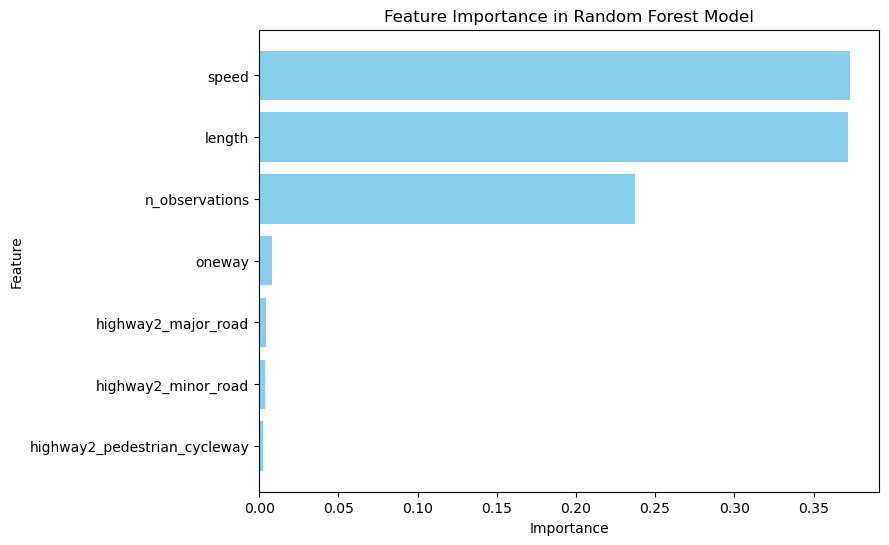

In [36]:
# Define features and target variable
features = [
    'oneway',       # Oneway (0 or 1)
    'length',       # Length of the street segment
    'speed',        # Average speed
    'n_observations',  # Traffic (number of observations)
    'highway2_major_road',  # Dummy for major roads
    'highway2_minor_road',  # Dummy for minor roads
    'highway2_pedestrian_cycleway'  # Dummy for pedestrian/cycleways
]

# Create the target variable (1 = severe accident, 0 = not severe)
street_accidents['is_severe'] = (street_accidents['n_severe'] > 0).astype(int)

# Subset the dataset to include only numeric features and the target
X = street_accidents[features]
y = street_accidents['is_severe']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model4xai = RandomForestClassifier(random_state=42)

# Train the model
model4xai.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model4xai.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Feature importance
importances = model4xai.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

#### **2.3. Explainability**

(a) How does `speed` affect the likelihood of severe accidents? Use a partial dependence plot and explain the resulting relationship on the train dataset.

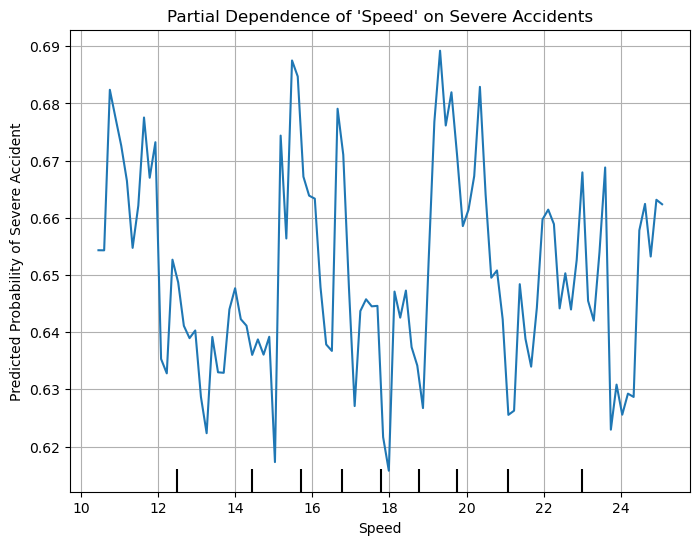

In [37]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay


# Generate partial dependence for the feature 'speed'
pdp = partial_dependence(model4xai, X=X_train, features=['speed'], kind='average')

# Plot the partial dependence
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(model4xai, X_train, ['speed'], ax=ax)
plt.title("Partial Dependence of 'Speed' on Severe Accidents")
plt.ylabel("Predicted Probability of Severe Accident")
plt.xlabel("Speed")
plt.grid()
plt.show()


Above, the partial dependence plot reveals a non-linear relationship between 'Speed' and the 'Predicted Probability of Severe Accident'. The probability fluctuates with speed, showing areas of higher and lower predicted risk, rather than a consistent increase or decrease. Specifically:

*   **Variable Risk:** The plot shows distinct peaks (higher risk) at specific speeds (e.g., just above 11, near 15, 19, 22 and 23) and dips (lower risk) at others (e.g., between 12 and 14, around 16, 20.5).
*   **Non-Monotonic:** The relationship is not directly proportional; the risk does not simply increase or decrease with higher speed.
*   **Fluctuations:** There is a significant change in the predicted probability, with a range of 0.04 in probability values, showing that the probability is greatly affected by small changes in speed.
*   **Baseline**: The overall risk of a severe accident is between 0.64 and 0.69.

This visual pattern suggests that certain speeds might be more dangerous than others, and that slower speeds do not necessarily imply consistent safety, as neither high speeds mean more risk.


(b) Use a SHAP `KernelExplainer` to compute the SHAP values for the test set.
As background parameter, use `shap.kmeans` to summarize the train dataset via 10 centroids.

In [38]:
# Summarize the training data using shap.kmeans (10 centroids)
background = shap.kmeans(X_train, 10)

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(model4xai.predict_proba, background)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

  0%|          | 0/3908 [00:00<?, ?it/s]

(c) Plot and explain a summary plot of the SHAP values. What insights can you get?

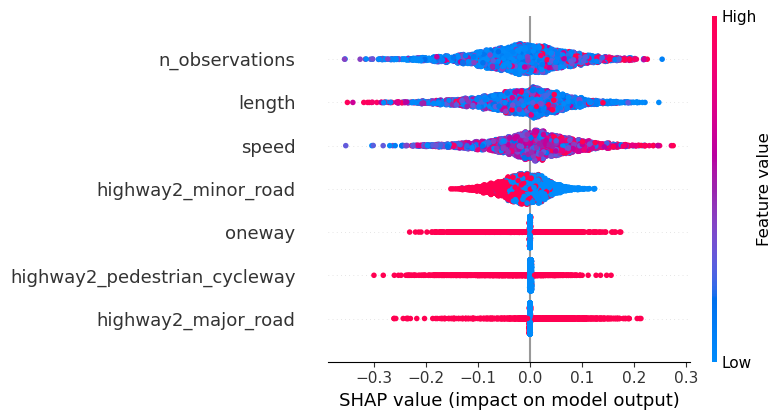

In [39]:
# Verify the shape
shap.summary_plot(shap_values[:,:,1], X_test)

As from its definition, the SHAP summary plot visually represents how each feature contributes to the random forest classifier's prediction of severe accidents. In this case, features such as "n_observations," "length," and "speed" exhibit a wide range of influence, both increasing and decreasing the predicted probability of a severe accident, with a tendency for higher feature values (red) to increase the risk, and lower feature values (blue) to reduce it. Conversely, the presence of a "highway2_minor_road" or a "highway2_major_road" tends to increase the model's prediction of a severe accident. In contrast, the existence of a "highway2_pedestrian_cycleway" is associated with a decreased likelihood of the model predicting a severe accident. The "oneway" feature appears to have an inconsistent impact, with a less clear relationship to the model’s output. Overall, the plot highlights that "n_observations", "length", and "speed" have the greatest variability in their impact, while showing that the features "highway2_minor_road", "highway2_major_road" and "highway2_pedestrian_cycleway" have consistent impact on the model.

(d) Take the first row of the test dataset: is it a "safe" street according to our model? Explain how each feature contributed to the final prediction.
Hint: use a waterfall plot.

Predicted Probability: [[0.26 0.74]]
Predicted Class: Severe


  0%|          | 0/1 [00:00<?, ?it/s]

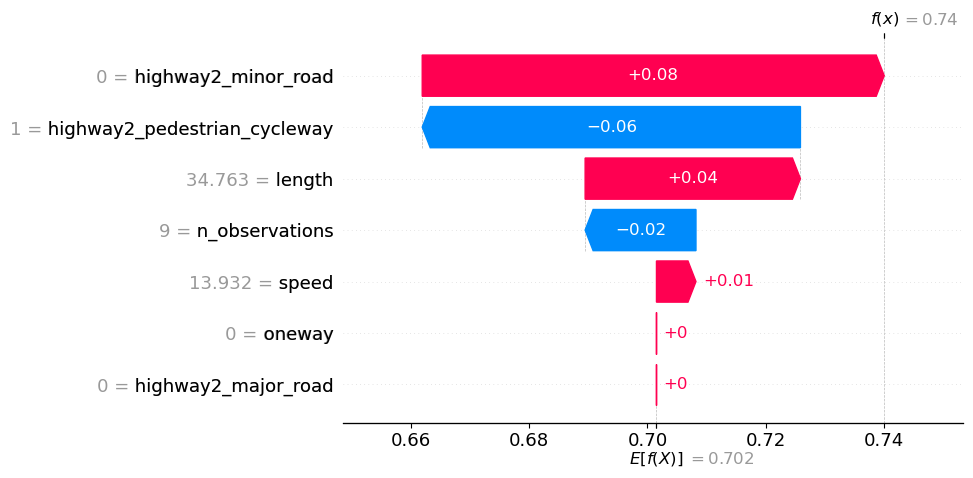

In [40]:
# Select the first row from the test dataset
first_row = X_test.iloc[0:1]

# Make the prediction and check the probability for "Severe"
predicted_proba = model4xai.predict_proba(first_row)
predicted_class = model4xai.predict(first_row)
print(f"Predicted Probability: {predicted_proba}")
print(f"Predicted Class: {'Severe' if predicted_class[0] == 1 else 'Safe'}")

# Compute SHAP values for the selected row
shap_values = explainer(first_row)

# Use the SHAP values for the "Severe" class (class index 1)
shap_values_for_severe = shap_values[:,:,1]

# Waterfall plot to explain the contribution of each feature
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_for_severe[0],              # SHAP values for the instance
        base_values= explainer.expected_value[1],      # Base value for "Severe"
        data=first_row.values[0],                      # Feature values
        feature_names=first_row.columns                # Feature names
    )
)



The first row’s prediction indicates the street is classified as “Severe” with a probability of 0.74 (as seen in the SHAP summary). This suggests the model does not consider the street “safe.” The waterfall plot reveals how individual features contributed to this decision:
	1.	Positive contributions to severity (unsafe):
	•	highway2_minor_road contributed +0.08.
	•	length contributed +0.04.
	2.	Negative contributions to severity (safe):
	•	highway2_pedestrian_cycleway contributed -0.06.
	•	n_observations contributed -0.02.

The remaining features (speed, oneway, and highway2_major_road) had marginal effects. Despite some negative contributions, the net effect pushed the probability toward “Severe.”

At the end:
- Longer road lengths and minor roads are associated with higher severity.
- Pedestrian/cycleway infrastructure reduces the risk.


(e) Compute the explanation you would get with LIME: how does it compare with SHAP? How can that be explained?

In [41]:
from lime.lime_tabular import LimeTabularExplainer

# Define a predict function that retains feature names
def predict_with_feature_names(data):
    data_df = pd.DataFrame(data, columns=features)  # Wrap data with feature names
    return model4xai.predict_proba(data_df)        # Use the model's predict_proba
    
# Initialize the LIME Tabular Explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,         # Training data as NumPy array
    training_labels=y_train.values,       # Training labels as NumPy array
    feature_names=features,               # Feature names
    class_names=['Not Severe', 'Severe'], # Class names
    mode='classification'                 # Classification mode
)

# Select a test sample to explain
sample_idx = 0  # Change this index to explain a different instance
sample = X_test.values[sample_idx].reshape(1, -1)

# Generate LIME explanation using the fixed predict function
lime_exp = lime_explainer.explain_instance(
    data_row=sample.flatten(),            # Instance to explain
    predict_fn=predict_with_feature_names # Custom predict function
)

# Visualize the explanation
lime_exp.show_in_notebook(show_table=True)

For the same entry, the LIME plot shows how features contribute to the prediction of “Severe” versus “Not Severe”:
	1.	Positive contributions to “Severe” (unsafe):
	•	n_observations > 4.00: Moderate contribution to “Severe.”
	•	speed <= 15.14: Small positive contribution.
	•	length > 12.42: Adds a small contribution to severity.
	2.	Neutral or marginal contributions:
	•	highway2_minor_road = 0.00: No influence in this case.
	•	oneway <= 0.00: Negligible contribution to severity.
	3.	Overall evaluation:
The positive contributions outweigh the neutral or negative ones, leading to the high severity prediction of 0.74.

Comparing LIME with SHAP:

In this analysis, both highlight the importance of certain features like length, n_observations, and speed as contributing factors to the severity prediction. However, SHAP provides exact contributions for each feature, whereas LIME’s explanation is based on a local approximation and thus is less precise. In addition, SHAP assigns contributions more evenly, while LIME approximates them based on proximity to similar samples.

### **3. Exploring explainability using accidents instances**

Use the `accident_street` dataset, containing accidents as rows.

#### **3.1. Data preparation**

(a) Simplify the columns following these remapping tables (1st column: original values, 2nd column: mapped values):

- Road type (as above, see highway2)

- Weather conditions

| WEATHER_1        | weather2     |
|-----------------|------------------|
| Dry           | clear            |
| Rain           | precipitation    |
| Snow/Hail    | precipitation    |
| Fog            | adverse          |
| Strong wind gusts| adverse          |
| Unknown       | other            |

- Surface Types Mapping

| ROAD_SURFACE_CONDITION                             | surface2 |
|--------------------------------------|--------------|
| Overig asfalt                        | asphalt      |
| ASFALT                               | asphalt      |
| ASVALT                               | asphalt      |
| ASFALT TEGELS                        | asphalt      |
| ASFALT FIETSPAD EN STOEPTEGELS       | asphalt      |
| ZOAB                                 | asphalt      |
| BITUMEN EN KLINKERS                  | asphalt      |
| KLINKERS OVERGAANDE IN BITUMEN       | asphalt      |
| BITUMEN FIETSPAD KLINKERWEG          | asphalt      |
| STOEPTEGELSFIETSPAD BITUMEN          | asphalt      |
| DEELS KLINKERS DEELS BITUMEN         | asphalt      |
| BITUMEN                              | asphalt      |
| KLINKERS EN BITUMEN                  | asphalt      |
| Klinkers                             | pavement     |
| Beton                                | pavement     |
| KEIEN                                | pavement     |
| STOEPTEGELS                          | pavement     |
| TEGELS                               | pavement     |
| 30 30 BETONTEGELS                    | pavement     |
| STOEPTEGELS 30X30                    | pavement     |
| TROTTOIR TEGELS                      | pavement     |
| STENEN                               | pavement     |
| TEGELS VOETPAD                       | pavement     |
| STRAATTEGELS                         | pavement     |
| KUNSTSTOF RIJPLATEN                  | pavement     |
| BETONNEN RIJPLATEN                   | pavement     |
| GRAS                                 | pavement     |
| TRAMRAILS MET DAARIN EEN GAT I       | other        |
| TRAMRAILS                            | other        |
| LOS GRAVEL                           | other        |
| IJZEREN ROOSTER                      | other        |
| GLAD WEGDEK                          | other        |
| KUNSTSTOF RIJPLATEN                  | other        |

- Road Light Conditions Mapping

| ROAD_LIGHT_CONDITION           | light2 |
|--------------------|--------------|
| Lit           | lit          |
| Not Lit      | not_lit      |
| Not present      | no_lighting  |


(b) Then create 0/1 dummies columns for each of `highway2`, `weather2`, `surface2`, `light2`. Create a `severe` column which is 1 if `AP3` is `Injury` or `Fatal`, 0 otherwise. Drop all non-numeric columns, rows with NAs and rows with `speed` = 0.

In [42]:
# Define the mapping for road type (highway -> highway2)
road_type_mapping = {
    'primary': 'major_road',
    'secondary': 'major_road',
    'tertiary': 'major_road',
    'primary_link': 'major_road',
    'secondary_link': 'major_road',
    'tertiary_link': 'major_road',
    'residential': 'minor_road',
    'unclassified': 'minor_road',
    'living_street': 'minor_road',
    'service': 'minor_road',
    'services': 'minor_road',
    'footway': 'pedestrian_cycleway',
    'pedestrian': 'pedestrian_cycleway',
    'cycleway': 'pedestrian_cycleway',
    'path': 'pedestrian_cycleway',
    'busway': 'public_transit'
}

accident_street['highway2'] = accident_street['highway'].map(road_type_mapping)

# Define the mapping for weather conditions (WEATHER_1 -> weather2)
weather_mapping = {
    'Dry': 'clear',
    'Rain': 'precipitation',
    'Snow/Hail': 'precipitation',
    'Fog': 'adverse',
    'Strong wind gusts': 'adverse',
    'Unknown': 'other'
}

accident_street['weather2'] = accident_street['WEATHER_1'].map(weather_mapping)

# Define the mapping for road surface condition to surface2
surface_mapping = {
    'Overig asfalt': 'asphalt',
    'ASFALT': 'asphalt',
    'ASVALT': 'asphalt',
    'ASFALT TEGELS': 'asphalt',
    'ASFALT FIETSPAD EN STOEPTEGELS': 'asphalt',
    'ZOAB': 'asphalt',
    'BITUMEN EN KLINKERS': 'asphalt',
    'KLINKERS OVERGAANDE IN BITUMEN': 'asphalt',
    'BITUMEN FIETSPAD KLINKERWEG': 'asphalt',
    'STOEPTEGELSFIETSPAD BITUMEN': 'asphalt',
    'DEELS KLINKERS DEELS BITUMEN': 'asphalt',
    'BITUMEN': 'asphalt',
    'KLINKERS EN BITUMEN': 'asphalt',
    'Klinkers': 'pavement',
    'Beton': 'pavement',
    'KEIEN': 'pavement',
    'STOEPTEGELS': 'pavement',
    'TEGELS': 'pavement',
    '30 30 BETONTEGELS': 'pavement',
    'STOEPTEGELS 30X30': 'pavement',
    'TROTTOIR TEGELS': 'pavement',
    'STENEN': 'pavement',
    'TEGELS VOETPAD': 'pavement',
    'STRAATTEGELS': 'pavement',
    'KUNSTSTOF RIJPLATEN': 'pavement',
    'BETONNEN RIJPLATEN': 'pavement',
    'GRAS': 'pavement',
    'TRAMRAILS MET DAARIN EEN GAT I': 'other',
    'TRAMRAILS': 'other',
    'LOS GRAVEL': 'other',
    'IJZEREN ROOSTER': 'other',
    'GLAD WEGDEK': 'other',
    'KUNSTSTOF RIJPLATEN': 'other'
}

# Apply the mapping to the ROAD_SURFACE_CONDITION column
accident_street['surface2'] = accident_street['ROAD_SURFACE_CONDITION'].map(surface_mapping)



# Replace NaN values in ROAD_LIGHT_CONDITION with 'Not present'
accident_street['ROAD_LIGHT_CONDITION'] = accident_street['ROAD_LIGHT_CONDITION'].fillna('Not present')

# Define the mapping for road light condition to light2
light_mapping = {
    'Lit': 'lit',
    'Not lit': 'not_lit',
    'Not present': 'no_lighting'
}

# Apply the mapping to the ROAD_LIGHT_CONDITION column
accident_street['light2'] = accident_street['ROAD_LIGHT_CONDITION'].map(light_mapping)


accident_street = pd.get_dummies(
    accident_street, 
    columns=['highway2', 'weather2', 'surface2', 'light2'], 
    drop_first=False  # Include all dummy variables to match the features
)

# Convert the oneway column to numeric (0 = False, 1 = True)
accident_street['oneway'] = accident_street['oneway'].astype(bool).astype(int)

# Dynamically find all dummy columns and convert them to integers
dummy_columns = [col for col in accident_street.columns if col.startswith(('highway2_', 'weather2_', 'surface2_', 'light2_'))]
accident_street[dummy_columns] = accident_street[dummy_columns].astype(int)


# Create the `severe` Column
accident_street['is_severe'] = (accident_street['AP3'].isin(['Injury', 'Fatal'])).astype(int)

# Select non-numeric columns and convert to a list
non_numeric_columns = accident_street.select_dtypes(exclude=['number']).columns.tolist()

# Append 'HECTOMETER' to the list of non-numeric columns
non_numeric_columns.extend(['HECTOMETER', 'JUNCTIxON_ID', ' X_COORD', 'Y_COORD'])

# Ensure the column list is valid and drop them from the DataFrame
accident_street = accident_street.drop(columns=[col for col in non_numeric_columns if col in accident_street.columns])


# Remove Rows with Missing Values
accident_street = accident_street.dropna()

# Remove Rows Where `speed` = 0
accident_street = accident_street[accident_street['speed'] > 0]



#### **3.2. Model preparation**

(a) Set up a classification model called `model4xai2` using a RandomForest to predict whether an accident is severe (i.e., involves death or injury).
Use as features:
- `oneway` (0 = false, 1 = true)
- `speed` (i.e. the average speed)
- `n_observations` (i.e. proxi of the traffic)
- the `highway2` dummies created above
- the `weather2` dummies created above
- the `surface2` dummies created above
- the `light2` dummies created above

In [ ]:
# Define feature columns

features = [
    'oneway',                 # Oneway (0 = False, 1 = True)
    'speed',                  # Average speed
    'n_observations',         # Proxy for traffic
    'highway2_major_road',    # Highway2 dummy for major road
    'highway2_minor_road',    # Highway2 dummy for minor road
    'highway2_pedestrian_cycleway',  # Highway2 dummy for pedestrian/cycleway
    'weather2_clear',         # Weather2 dummy for clear weather
    'weather2_precipitation', # Weather2 dummy for precipitation
    'weather2_adverse',       # Weather2 dummy for adverse conditions
    'weather2_other',         # Weather2 dummy for other conditions
    'surface2_asphalt',       # Surface2 dummy for asphalt
    'surface2_pavement',      # Surface2 dummy for pavement
    'surface2_other',         # Surface2 dummy for other surfaces
    'light2_lit',             # Light2 dummy for lit roads
    'light2_not_lit',         # Light2 dummy for not lit roads
    'light2_no_lighting'      # Light2 dummy for roads with no lighting
]

# Filter the dataset to include only the selected features and the target
X = accident_street[features]
print(X.head())
y = accident_street['is_severe']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
model4xai2 = RandomForestClassifier(random_state=42)
model4xai2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model4xai2.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

y_test.shape

   oneway    speed  n_observations  highway2_major_road  highway2_minor_road  \
3       0  15.8505            21.0                    0                    1   
3       0  17.9770            41.0                    0                    1   
3       0  17.9770            41.0                    0                    1   
3       0  17.4276            19.0                    0                    1   
3       0  17.9770            41.0                    0                    1   

   highway2_pedestrian_cycleway  weather2_clear  weather2_precipitation  \
3                             0               1                       0   
3                             0               1                       0   
3                             0               1                       0   
3                             0               1                       0   
3                             0               1                       0   

   weather2_adverse  weather2_other  surface2_asphalt  surface2_pave

(6969,)

#### **3.3. Explainability**

(a) Use a SHAP `KernelExplainer` to compute the SHAP values for the test set.
As background parameter, use `shap.kmeans` to summarize the train dataset via 10 centroids.

  0%|          | 0/6969 [00:00<?, ?it/s]

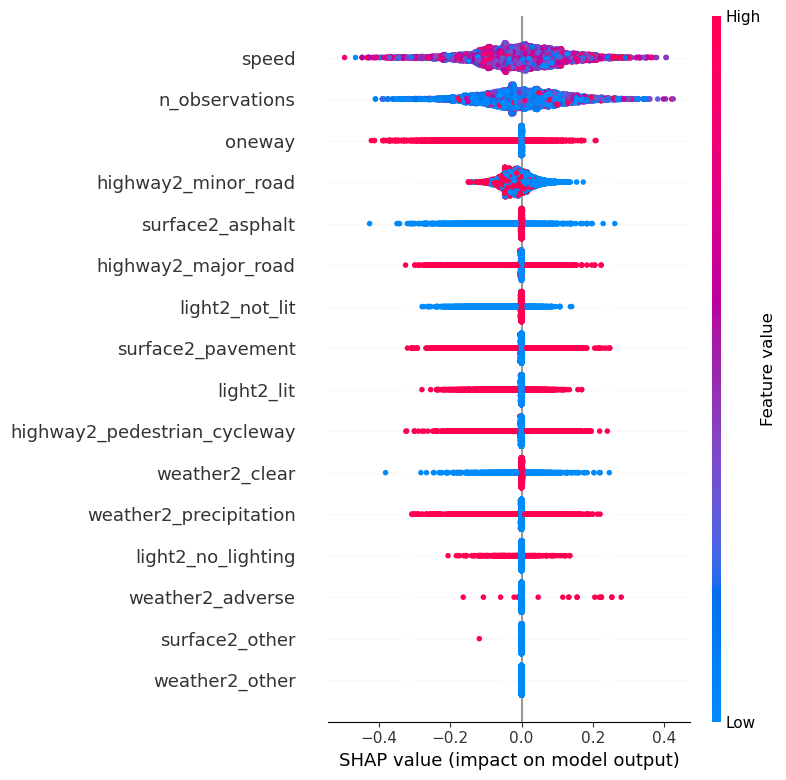

In [44]:
# Summarize the training dataset using 10 centroids
background2 = shap.kmeans(X_train, 10)

# Reinitialize KernelExplainer with the correct background
explainer2 = shap.KernelExplainer(model4xai2.predict_proba, background2)

# Compute SHAP values for the full test subset
shap_values2 = explainer2(X_test)

# Verify the shape
shap.summary_plot(shap_values2[:,:,1], X_test)

The SHAP summary plot highlights that speed and n_observations are the most critical features influencing the model’s predictions. Higher speed values generally increase the likelihood of severity, as indicated by higher positive SHAP values for larger speeds. On the other hand, higher n_observations tend to decrease the likelihood of severity, with negative SHAP values for larger observation counts. Features like oneway and highway2_minor_road have a much smaller and less consistent impact, indicating they are not as significant in determining severity outcomes.

(b) What are the 3 most important features? Use a summary BAR plot.

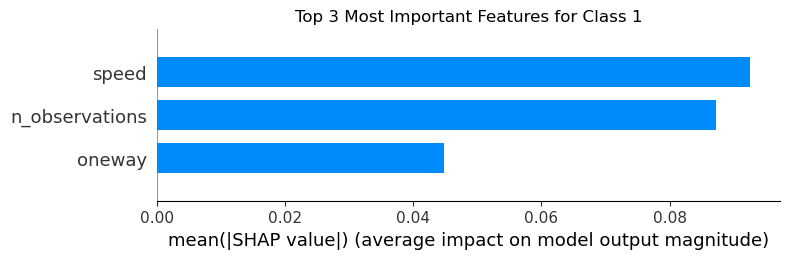

In [45]:
plt.title("Top 3 Most Important Features for Class 1")
# Generate a summary bar plot for the top 3 features
shap.summary_plot(
    shap_values2[:,:,1], 
    X_test, 
    plot_type="bar", 
    max_display=3
)

The plot clearly indicates that speed, n_observations, and oneway are the three most important features, with speed having the largest average impact on the model's output, followed by n_observations and then oneway. Moreover, the length of the bars represents the magnitude of the average impact of each feature on the model's prediction.

(c) Plot a scatter plot of speed (x-axis) vs its SHAP value (y-axis). What is the difference with the partial dependence plot?

Hint: use shap.plots.scatter

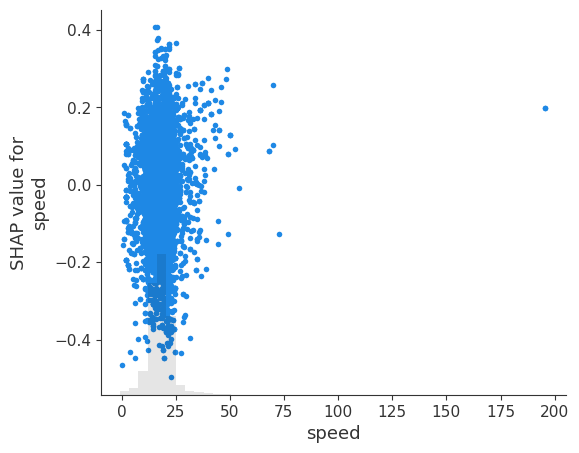

In [46]:
shap.plots.scatter(shap_values2[:, 'speed',1])

The speed scatter plot provides detailed insights into the relationship between speed and its impact on predictions. For most data points, speed has a small or negligible effect, with SHAP values clustering near zero for lower speed values. However, there are instances where high speed values lead to substantial increases in the severity prediction, as seen in the positive SHAP values. This pattern suggests that while speed is not always a dominant factor, it plays a critical role in specific scenarios, potentially identifying high-risk cases.

### **4. Reflection**
- (a) How do the two analyses with the two datasets above differ? What are instead the similiarities?
- (b) What are the benefits of a XAI-informed model for predicting severe accidents? What could be the risks?



**(a) Differences and similarities between the two analyses**

**Differences:**

1. The first analysis focuses on **aggregated street-level data**, combining multiple accidents to analyze trends for each street. This provides a broader and long-term perspective. The second analysis examines **individual incidents**, focusing on specific conditions at the time of each accident.

2. The **street-level model** emphasizes features like average speed, traffic volume (`n_observations`), and road type, which reflect cumulative structural factors. The **incident-level model** highlights transient factors like weather, lighting, and surface conditions, representing immediate accident circumstances.

3. Aggregated data smooths out short-term conditions, making infrastructure characteristics more prominent. Incident-specific data captures variability in immediate conditions such as adverse weather or lighting.

**Similarities:**

1. Both analyses identify **speed** as a critical factor in accident severity, highlighting its importance in both long-term and short-term contexts.

2. Lighting conditions (e.g., `light2_lit`, `light2_not_lit`) and road types (e.g., `highway2_minor_road`, `highway2_major_road`) are significant in both models, though their importance varies between analyses.

3. Both methodologies use SHAP values to explain feature contributions, ensuring transparency and interpretability in predictions.

---

**(b) Benefits and risks of an explainable model**

**Benefits:**

1. **Interpretability:** Tools like SHAP provide clear insights into why features like speed or lighting contribute to accident severity, making models more transparent.

2. **Actionable insights:** Street-level analysis supports long-term urban planning, while incident-level analysis identifies immediate risk factors for safety improvements.

3. **Resource prioritization:** Highlighting influential features allows targeted interventions, such as improving lighting or implementing speed control measures on high-risk streets.

4. **Improved decision-making:** The combination of aggregated and individual data provides complementary insights, supporting both strategic planning and operational responses.

**Risks:**

1. **Data bias:** Aggregated data may mask rare but significant conditions, while incident-specific data might overemphasize short-term factors.

2. **Overgeneralization:** Applying insights from one level of analysis (e.g., street-level) to another (e.g., incidents) may lead to incorrect conclusions or suboptimal policies.

3. **Complexity:** Non-technical users may find it difficult to interpret SHAP outputs, limiting their understanding of the model’s predictions.

4. **Ethical concerns:** If the data contains systemic biases (e.g., underreporting from specific areas), the model might reinforce inequalities in interventions.